## Mask RCNN


In [3]:
import datetime
import os
import sys
import json
import numpy as np
import time
import tensorflow as tf
from PIL import Image, ImageDraw

In [16]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../../aktwelve_Mask_RCNN'
assert os.path.exists(ROOT_DIR)

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib


In [14]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


## Configuration
Define configuration for new dataset


In [6]:
class MallConfig(Config):
    """Configuration for training on the classroom_data dataset.
    Derives from the base Config class and overrides values specific
    to the classroom_data dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Mall"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    LEARNING_RATE = 0.002

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # background + person 

    # Change this later based on the dimension of images formed from extracting from video
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 320

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 200

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 4
    
    BACKBONE = 'resnet101'

    RPN_ANCHOR_SCALES = (16, 32, 64, 128,256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 

    
config = MallConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

# Define the dataset


In [7]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets


In [8]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('../datasets/shopping in portugal/train/trainval.json', '../datasets/shopping in portugal/train/images/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('../datasets/shopping in portugal/val/trainval.json', '../datasets/shopping in portugal/val/images/')
dataset_val.prepare()

## Display a few images from the training dataset

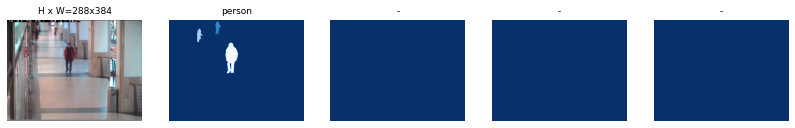

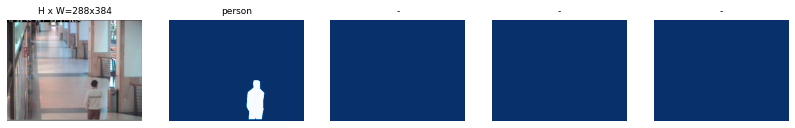

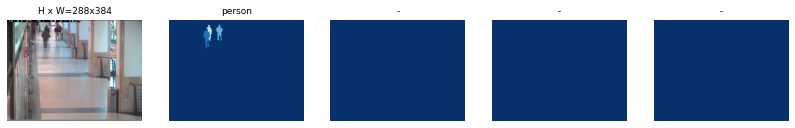

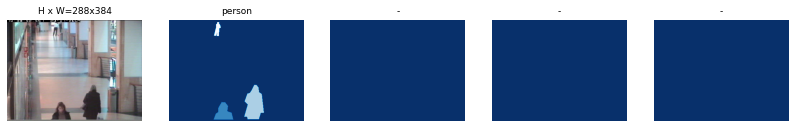

In [17]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train


In [121]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [122]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

# Training
Train in two stages:

1.Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2.Fine-tune all layers.

In [123]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5,
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.002

Checkpoint Path: ../../aktwelve_Mask_RCNN\logs\mall20210423T2158\mask_rcnn_mall_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv     

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_8/SGD/gradients/gradients/roi_align_classifier_12/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_8/SGD/gradients/gradients/roi_align_classifier_12/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_8/SGD/gradients/gradients/roi_align_classifier_12/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. Thi

  1/200 [..............................] - ETA: 47:13 - batch: 0.0000e+00 - size: 1.0000 - loss: 2.6155 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 1.5604 - mrcnn_class_loss: 1.0352 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/200 [..............................] - ETA: 12:08 - batch: 0.5000 - size: 1.0000 - loss: 3.3513 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 1.1992 - mrcnn_class_loss: 0.6043 - mrcnn_bbox_loss: 0.6066 - mrcnn_mask_loss: 0.9147            

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/200 [..............................] - ETA: 11:58 - batch: 1.0000 - size: 1.0000 - loss: 3.3289 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 1.0309 - mrcnn_class_loss: 0.7239 - mrcnn_bbox_loss: 0.6523 - mrcnn_mask_loss: 0.8916

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/200 [..............................] - ETA: 11:49 - batch: 1.5000 - size: 1.0000 - loss: 3.1094 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.9055 - mrcnn_class_loss: 0.6872 - mrcnn_bbox_loss: 0.6738 - mrcnn_mask_loss: 0.8139

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/200 [..............................] - ETA: 11:51 - batch: 2.0000 - size: 1.0000 - loss: 3.0204 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.8405 - mrcnn_class_loss: 0.6100 - mrcnn_bbox_loss: 0.7454 - mrcnn_mask_loss: 0.8005

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/200 [..............................] - ETA: 11:46 - batch: 2.5000 - size: 1.0000 - loss: 2.8598 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.7929 - mrcnn_class_loss: 0.5197 - mrcnn_bbox_loss: 0.7758 - mrcnn_mask_loss: 0.7504

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/200 [>.............................] - ETA: 11:46 - batch: 3.0000 - size: 1.0000 - loss: 2.8401 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.7720 - mrcnn_class_loss: 0.4995 - mrcnn_bbox_loss: 0.8460 - mrcnn_mask_loss: 0.7018

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/200 [>.............................] - ETA: 11:43 - batch: 3.5000 - size: 1.0000 - loss: 2.6993 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.7146 - mrcnn_class_loss: 0.4664 - mrcnn_bbox_loss: 0.8380 - mrcnn_mask_loss: 0.6600

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/200 [>.............................] - ETA: 11:40 - batch: 4.0000 - size: 1.0000 - loss: 2.6160 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.6736 - mrcnn_class_loss: 0.4362 - mrcnn_bbox_loss: 0.8410 - mrcnn_mask_loss: 0.6436

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/200 [>.............................] - ETA: 11:37 - batch: 4.5000 - size: 1.0000 - loss: 2.5097 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.6378 - mrcnn_class_loss: 0.4545 - mrcnn_bbox_loss: 0.7959 - mrcnn_mask_loss: 0.6018

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/200 [>.............................] - ETA: 11:33 - batch: 5.0000 - size: 1.0000 - loss: 2.4753 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.6343 - mrcnn_class_loss: 0.4281 - mrcnn_bbox_loss: 0.8139 - mrcnn_mask_loss: 0.5800

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/200 [>.............................] - ETA: 11:30 - batch: 5.5000 - size: 1.0000 - loss: 2.4078 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.6038 - mrcnn_class_loss: 0.4146 - mrcnn_bbox_loss: 0.8137 - mrcnn_mask_loss: 0.5576

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/200 [>.............................] - ETA: 11:26 - batch: 6.0000 - size: 1.0000 - loss: 2.3363 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5824 - mrcnn_class_loss: 0.4013 - mrcnn_bbox_loss: 0.8042 - mrcnn_mask_loss: 0.5313

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/200 [=>............................] - ETA: 11:27 - batch: 6.5000 - size: 1.0000 - loss: 2.2864 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5729 - mrcnn_class_loss: 0.3749 - mrcnn_bbox_loss: 0.8034 - mrcnn_mask_loss: 0.5189

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/200 [=>............................] - ETA: 11:23 - batch: 7.0000 - size: 1.0000 - loss: 2.2422 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.5691 - mrcnn_class_loss: 0.3519 - mrcnn_bbox_loss: 0.7943 - mrcnn_mask_loss: 0.5108

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/200 [=>............................] - ETA: 11:20 - batch: 7.5000 - size: 1.0000 - loss: 2.1943 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5425 - mrcnn_class_loss: 0.3301 - mrcnn_bbox_loss: 0.7877 - mrcnn_mask_loss: 0.5188

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/200 [=>............................] - ETA: 11:21 - batch: 8.0000 - size: 1.0000 - loss: 2.1928 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5435 - mrcnn_class_loss: 0.3170 - mrcnn_bbox_loss: 0.7920 - mrcnn_mask_loss: 0.5254

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/200 [=>............................] - ETA: 11:17 - batch: 8.5000 - size: 1.0000 - loss: 2.1658 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.5294 - mrcnn_class_loss: 0.3186 - mrcnn_bbox_loss: 0.7892 - mrcnn_mask_loss: 0.5125

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/200 [=>............................] - ETA: 11:12 - batch: 9.0000 - size: 1.0000 - loss: 2.1397 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5214 - mrcnn_class_loss: 0.3026 - mrcnn_bbox_loss: 0.7920 - mrcnn_mask_loss: 0.5082

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/200 [==>...........................] - ETA: 11:08 - batch: 9.5000 - size: 1.0000 - loss: 2.0869 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5121 - mrcnn_class_loss: 0.2943 - mrcnn_bbox_loss: 0.7675 - mrcnn_mask_loss: 0.4981

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/200 [==>...........................] - ETA: 11:04 - batch: 10.0000 - size: 1.0000 - loss: 2.0891 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5163 - mrcnn_class_loss: 0.2857 - mrcnn_bbox_loss: 0.7816 - mrcnn_mask_loss: 0.4910

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/200 [==>...........................] - ETA: 11:00 - batch: 10.5000 - size: 1.0000 - loss: 2.0784 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5085 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.7718 - mrcnn_mask_loss: 0.4844

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/200 [==>...........................] - ETA: 10:58 - batch: 11.0000 - size: 1.0000 - loss: 2.0793 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4912 - mrcnn_class_loss: 0.2922 - mrcnn_bbox_loss: 0.7894 - mrcnn_mask_loss: 0.4922

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/200 [==>...........................] - ETA: 10:54 - batch: 11.5000 - size: 1.0000 - loss: 2.0448 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4874 - mrcnn_class_loss: 0.2840 - mrcnn_bbox_loss: 0.7743 - mrcnn_mask_loss: 0.4850

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/200 [==>...........................] - ETA: 10:50 - batch: 12.0000 - size: 1.0000 - loss: 2.0892 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5153 - mrcnn_class_loss: 0.3034 - mrcnn_bbox_loss: 0.7688 - mrcnn_mask_loss: 0.4866

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/200 [==>...........................] - ETA: 10:49 - batch: 12.5000 - size: 1.0000 - loss: 2.0549 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5058 - mrcnn_class_loss: 0.2972 - mrcnn_bbox_loss: 0.7566 - mrcnn_mask_loss: 0.4801

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/200 [===>..........................] - ETA: 10:45 - batch: 13.0000 - size: 1.0000 - loss: 2.0565 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5099 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.7516 - mrcnn_mask_loss: 0.4841

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/200 [===>..........................] - ETA: 10:41 - batch: 13.5000 - size: 1.0000 - loss: 2.0659 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5205 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.7508 - mrcnn_mask_loss: 0.4849

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/200 [===>..........................] - ETA: 10:39 - batch: 14.0000 - size: 1.0000 - loss: 2.0417 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5191 - mrcnn_class_loss: 0.2883 - mrcnn_bbox_loss: 0.7444 - mrcnn_mask_loss: 0.4750

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/200 [===>..........................] - ETA: 10:35 - batch: 14.5000 - size: 1.0000 - loss: 2.0334 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.2884 - mrcnn_bbox_loss: 0.7379 - mrcnn_mask_loss: 0.4725

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/200 [===>..........................] - ETA: 10:31 - batch: 15.0000 - size: 1.0000 - loss: 2.0176 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.5107 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.7400 - mrcnn_mask_loss: 0.4681

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/200 [===>..........................] - ETA: 10:27 - batch: 15.5000 - size: 1.0000 - loss: 2.0039 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5067 - mrcnn_class_loss: 0.2759 - mrcnn_bbox_loss: 0.7386 - mrcnn_mask_loss: 0.4662

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/200 [===>..........................] - ETA: 10:22 - batch: 16.0000 - size: 1.0000 - loss: 1.9850 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5046 - mrcnn_class_loss: 0.2696 - mrcnn_bbox_loss: 0.7312 - mrcnn_mask_loss: 0.4633

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/200 [====>.........................] - ETA: 10:21 - batch: 16.5000 - size: 1.0000 - loss: 1.9616 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4989 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.7248 - mrcnn_mask_loss: 0.4554

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/200 [====>.........................] - ETA: 10:21 - batch: 17.0000 - size: 1.0000 - loss: 1.9377 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4994 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.7103 - mrcnn_mask_loss: 0.4519

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/200 [====>.........................] - ETA: 10:18 - batch: 17.5000 - size: 1.0000 - loss: 1.9450 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.5003 - mrcnn_class_loss: 0.2730 - mrcnn_bbox_loss: 0.7054 - mrcnn_mask_loss: 0.4487

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/200 [====>.........................] - ETA: 10:15 - batch: 18.0000 - size: 1.0000 - loss: 1.9231 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4991 - mrcnn_class_loss: 0.2661 - mrcnn_bbox_loss: 0.6949 - mrcnn_mask_loss: 0.4456

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/200 [====>.........................] - ETA: 10:12 - batch: 18.5000 - size: 1.0000 - loss: 1.8964 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4931 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.6818 - mrcnn_mask_loss: 0.4444

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/200 [====>.........................] - ETA: 10:08 - batch: 19.0000 - size: 1.0000 - loss: 1.8958 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4911 - mrcnn_class_loss: 0.2609 - mrcnn_bbox_loss: 0.6806 - mrcnn_mask_loss: 0.4456

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/200 [=====>........................] - ETA: 10:03 - batch: 19.5000 - size: 1.0000 - loss: 1.8782 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4834 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.6787 - mrcnn_mask_loss: 0.4402

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/200 [=====>........................] - ETA: 9:58 - batch: 20.0000 - size: 1.0000 - loss: 1.8550 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4777 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.6700 - mrcnn_mask_loss: 0.4349 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/200 [=====>........................] - ETA: 9:54 - batch: 20.5000 - size: 1.0000 - loss: 1.8325 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4714 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.6599 - mrcnn_mask_loss: 0.4318

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/200 [=====>........................] - ETA: 9:49 - batch: 21.0000 - size: 1.0000 - loss: 1.8136 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4666 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.6528 - mrcnn_mask_loss: 0.4281

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/200 [=====>........................] - ETA: 9:45 - batch: 21.5000 - size: 1.0000 - loss: 1.8642 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4655 - mrcnn_class_loss: 0.2915 - mrcnn_bbox_loss: 0.6579 - mrcnn_mask_loss: 0.4306

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/200 [=====>........................] - ETA: 9:42 - batch: 22.0000 - size: 1.0000 - loss: 1.8766 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.4750 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.6566 - mrcnn_mask_loss: 0.4295

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/200 [=====>........................] - ETA: 9:41 - batch: 22.5000 - size: 1.0000 - loss: 1.8791 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.4797 - mrcnn_class_loss: 0.2963 - mrcnn_bbox_loss: 0.6514 - mrcnn_mask_loss: 0.4305

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/200 [======>.......................] - ETA: 9:38 - batch: 23.0000 - size: 1.0000 - loss: 1.8583 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.4737 - mrcnn_class_loss: 0.2922 - mrcnn_bbox_loss: 0.6437 - mrcnn_mask_loss: 0.4279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/200 [======>.......................] - ETA: 9:34 - batch: 23.5000 - size: 1.0000 - loss: 1.8760 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.4853 - mrcnn_class_loss: 0.2897 - mrcnn_bbox_loss: 0.6484 - mrcnn_mask_loss: 0.4317

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/200 [======>.......................] - ETA: 9:30 - batch: 24.0000 - size: 1.0000 - loss: 1.8738 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.4893 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.6446 - mrcnn_mask_loss: 0.4328

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/200 [======>.......................] - ETA: 9:27 - batch: 24.5000 - size: 1.0000 - loss: 1.8713 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.4836 - mrcnn_class_loss: 0.2909 - mrcnn_bbox_loss: 0.6423 - mrcnn_mask_loss: 0.4340

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/200 [======>.......................] - ETA: 9:23 - batch: 25.0000 - size: 1.0000 - loss: 1.8637 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.4790 - mrcnn_class_loss: 0.2886 - mrcnn_bbox_loss: 0.6449 - mrcnn_mask_loss: 0.4307

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/200 [======>.......................] - ETA: 9:19 - batch: 25.5000 - size: 1.0000 - loss: 1.8478 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.4727 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.6410 - mrcnn_mask_loss: 0.4284

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/200 [======>.......................] - ETA: 9:15 - batch: 26.0000 - size: 1.0000 - loss: 1.8268 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.4657 - mrcnn_class_loss: 0.2808 - mrcnn_bbox_loss: 0.6343 - mrcnn_mask_loss: 0.4260

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/200 [=======>......................] - ETA: 9:11 - batch: 26.5000 - size: 1.0000 - loss: 1.8150 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4627 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.6319 - mrcnn_mask_loss: 0.4233

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/200 [=======>......................] - ETA: 9:08 - batch: 27.0000 - size: 1.0000 - loss: 1.8109 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.4620 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.6294 - mrcnn_mask_loss: 0.4225

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/200 [=======>......................] - ETA: 9:04 - batch: 27.5000 - size: 1.0000 - loss: 1.8073 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.4570 - mrcnn_class_loss: 0.2835 - mrcnn_bbox_loss: 0.6258 - mrcnn_mask_loss: 0.4212

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/200 [=======>......................] - ETA: 8:59 - batch: 28.0000 - size: 1.0000 - loss: 1.7933 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.4509 - mrcnn_class_loss: 0.2792 - mrcnn_bbox_loss: 0.6259 - mrcnn_mask_loss: 0.4177

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/200 [=======>......................] - ETA: 8:55 - batch: 28.5000 - size: 1.0000 - loss: 1.7910 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.6231 - mrcnn_mask_loss: 0.4169

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/200 [=======>......................] - ETA: 8:51 - batch: 29.0000 - size: 1.0000 - loss: 1.7829 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.4497 - mrcnn_class_loss: 0.2758 - mrcnn_bbox_loss: 0.6219 - mrcnn_mask_loss: 0.4165

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/200 [========>.....................] - ETA: 8:47 - batch: 29.5000 - size: 1.0000 - loss: 1.7700 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.4455 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.6158 - mrcnn_mask_loss: 0.4143

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/200 [========>.....................] - ETA: 8:43 - batch: 30.0000 - size: 1.0000 - loss: 1.7658 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.4433 - mrcnn_class_loss: 0.2730 - mrcnn_bbox_loss: 0.6180 - mrcnn_mask_loss: 0.4127

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/200 [========>.....................] - ETA: 8:38 - batch: 30.5000 - size: 1.0000 - loss: 1.7576 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4416 - mrcnn_class_loss: 0.2701 - mrcnn_bbox_loss: 0.6148 - mrcnn_mask_loss: 0.4124

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/200 [========>.....................] - ETA: 8:34 - batch: 31.0000 - size: 1.0000 - loss: 1.7515 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4432 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.6127 - mrcnn_mask_loss: 0.4088

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/200 [========>.....................] - ETA: 8:31 - batch: 31.5000 - size: 1.0000 - loss: 1.7399 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4387 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.6070 - mrcnn_mask_loss: 0.4086

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/200 [========>.....................] - ETA: 8:27 - batch: 32.0000 - size: 1.0000 - loss: 1.7275 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4351 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.6041 - mrcnn_mask_loss: 0.4066

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/200 [========>.....................] - ETA: 8:23 - batch: 32.5000 - size: 1.0000 - loss: 1.7292 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4335 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.6039 - mrcnn_mask_loss: 0.4069

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/200 [=========>....................] - ETA: 8:19 - batch: 33.0000 - size: 1.0000 - loss: 1.7248 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4320 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.6040 - mrcnn_mask_loss: 0.4062

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/200 [=========>....................] - ETA: 8:15 - batch: 33.5000 - size: 1.0000 - loss: 1.7164 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4284 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.6055 - mrcnn_mask_loss: 0.4027

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/200 [=========>....................] - ETA: 8:12 - batch: 34.0000 - size: 1.0000 - loss: 1.7139 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4277 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.6051 - mrcnn_mask_loss: 0.4032

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/200 [=========>....................] - ETA: 8:08 - batch: 34.5000 - size: 1.0000 - loss: 1.7076 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4260 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.5996 - mrcnn_mask_loss: 0.4014

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/200 [=========>....................] - ETA: 8:05 - batch: 35.0000 - size: 1.0000 - loss: 1.6954 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4261 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.5945 - mrcnn_mask_loss: 0.3977

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/200 [=========>....................] - ETA: 8:01 - batch: 35.5000 - size: 1.0000 - loss: 1.6921 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.5932 - mrcnn_mask_loss: 0.3983

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/200 [=========>....................] - ETA: 7:57 - batch: 36.0000 - size: 1.0000 - loss: 1.6806 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4231 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.5898 - mrcnn_mask_loss: 0.3958

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/200 [==========>...................] - ETA: 7:53 - batch: 36.5000 - size: 1.0000 - loss: 1.6703 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4209 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.5850 - mrcnn_mask_loss: 0.3931

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/200 [==========>...................] - ETA: 7:49 - batch: 37.0000 - size: 1.0000 - loss: 1.6533 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4156 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.5779 - mrcnn_mask_loss: 0.3917

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/200 [==========>...................] - ETA: 7:46 - batch: 37.5000 - size: 1.0000 - loss: 1.6407 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4130 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.5735 - mrcnn_mask_loss: 0.3884

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/200 [==========>...................] - ETA: 7:42 - batch: 38.0000 - size: 1.0000 - loss: 1.6335 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4112 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.5718 - mrcnn_mask_loss: 0.3864

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/200 [==========>...................] - ETA: 7:38 - batch: 38.5000 - size: 1.0000 - loss: 1.6327 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4125 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.5699 - mrcnn_mask_loss: 0.3849

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/200 [==========>...................] - ETA: 7:34 - batch: 39.0000 - size: 1.0000 - loss: 1.6233 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.4109 - mrcnn_class_loss: 0.2442 - mrcnn_bbox_loss: 0.5675 - mrcnn_mask_loss: 0.3825

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/200 [===========>..................] - ETA: 7:31 - batch: 39.5000 - size: 1.0000 - loss: 1.6148 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.5644 - mrcnn_mask_loss: 0.3822

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/200 [===========>..................] - ETA: 7:28 - batch: 40.0000 - size: 1.0000 - loss: 1.6100 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4068 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.5607 - mrcnn_mask_loss: 0.3810

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/200 [===========>..................] - ETA: 7:24 - batch: 40.5000 - size: 1.0000 - loss: 1.6028 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.5582 - mrcnn_mask_loss: 0.3800

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/200 [===========>..................] - ETA: 7:21 - batch: 41.0000 - size: 1.0000 - loss: 1.6083 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4075 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.5591 - mrcnn_mask_loss: 0.3793

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/200 [===========>..................] - ETA: 7:18 - batch: 41.5000 - size: 1.0000 - loss: 1.5983 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.5568 - mrcnn_mask_loss: 0.3767

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/200 [===========>..................] - ETA: 7:15 - batch: 42.0000 - size: 1.0000 - loss: 1.5977 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.5544 - mrcnn_mask_loss: 0.3760

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/200 [===========>..................] - ETA: 7:11 - batch: 42.5000 - size: 1.0000 - loss: 1.5964 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4100 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.5519 - mrcnn_mask_loss: 0.3753

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/200 [============>.................] - ETA: 7:08 - batch: 43.0000 - size: 1.0000 - loss: 1.5933 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4098 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.5489 - mrcnn_mask_loss: 0.3745

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/200 [============>.................] - ETA: 7:04 - batch: 43.5000 - size: 1.0000 - loss: 1.5874 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4117 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.5453 - mrcnn_mask_loss: 0.3722

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/200 [============>.................] - ETA: 7:01 - batch: 44.0000 - size: 1.0000 - loss: 1.5788 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4119 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.5405 - mrcnn_mask_loss: 0.3704

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/200 [============>.................] - ETA: 6:57 - batch: 44.5000 - size: 1.0000 - loss: 1.5726 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4113 - mrcnn_class_loss: 0.2361 - mrcnn_bbox_loss: 0.5385 - mrcnn_mask_loss: 0.3692

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/200 [============>.................] - ETA: 6:55 - batch: 45.0000 - size: 1.0000 - loss: 1.5674 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.2338 - mrcnn_bbox_loss: 0.5378 - mrcnn_mask_loss: 0.3691

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/200 [============>.................] - ETA: 6:51 - batch: 45.5000 - size: 1.0000 - loss: 1.5614 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4075 - mrcnn_class_loss: 0.2331 - mrcnn_bbox_loss: 0.5347 - mrcnn_mask_loss: 0.3688

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/200 [============>.................] - ETA: 6:47 - batch: 46.0000 - size: 1.0000 - loss: 1.5552 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4092 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.5303 - mrcnn_mask_loss: 0.3675

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/200 [=============>................] - ETA: 6:44 - batch: 46.5000 - size: 1.0000 - loss: 1.5563 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4101 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.5287 - mrcnn_mask_loss: 0.3673

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/200 [=============>................] - ETA: 6:40 - batch: 47.0000 - size: 1.0000 - loss: 1.5488 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4076 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.5246 - mrcnn_mask_loss: 0.3668

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/200 [=============>................] - ETA: 6:36 - batch: 47.5000 - size: 1.0000 - loss: 1.5478 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4097 - mrcnn_class_loss: 0.2302 - mrcnn_bbox_loss: 0.5234 - mrcnn_mask_loss: 0.3675

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/200 [=============>................] - ETA: 6:32 - batch: 48.0000 - size: 1.0000 - loss: 1.5383 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4071 - mrcnn_class_loss: 0.2290 - mrcnn_bbox_loss: 0.5198 - mrcnn_mask_loss: 0.3654

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/200 [=============>................] - ETA: 6:28 - batch: 48.5000 - size: 1.0000 - loss: 1.5383 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4083 - mrcnn_class_loss: 0.2297 - mrcnn_bbox_loss: 0.5196 - mrcnn_mask_loss: 0.3637

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/200 [=============>................] - ETA: 6:24 - batch: 49.0000 - size: 1.0000 - loss: 1.5373 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4091 - mrcnn_class_loss: 0.2307 - mrcnn_bbox_loss: 0.5177 - mrcnn_mask_loss: 0.3629

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/200 [==============>...............] - ETA: 6:20 - batch: 49.5000 - size: 1.0000 - loss: 1.5355 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4096 - mrcnn_class_loss: 0.2289 - mrcnn_bbox_loss: 0.5173 - mrcnn_mask_loss: 0.3629

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/200 [==============>...............] - ETA: 6:17 - batch: 50.0000 - size: 1.0000 - loss: 1.5314 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4095 - mrcnn_class_loss: 0.2271 - mrcnn_bbox_loss: 0.5162 - mrcnn_mask_loss: 0.3619

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/200 [==============>...............] - ETA: 6:13 - batch: 50.5000 - size: 1.0000 - loss: 1.5256 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4087 - mrcnn_class_loss: 0.2250 - mrcnn_bbox_loss: 0.5132 - mrcnn_mask_loss: 0.3620

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/200 [==============>...............] - ETA: 6:09 - batch: 51.0000 - size: 1.0000 - loss: 1.5181 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.5101 - mrcnn_mask_loss: 0.3619

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/200 [==============>...............] - ETA: 6:05 - batch: 51.5000 - size: 1.0000 - loss: 1.5183 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4112 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.5079 - mrcnn_mask_loss: 0.3606

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/200 [==============>...............] - ETA: 6:02 - batch: 52.0000 - size: 1.0000 - loss: 1.5090 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.3585

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/200 [==============>...............] - ETA: 5:58 - batch: 52.5000 - size: 1.0000 - loss: 1.5147 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4098 - mrcnn_class_loss: 0.2215 - mrcnn_bbox_loss: 0.5056 - mrcnn_mask_loss: 0.3615

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/200 [===============>..............] - ETA: 5:54 - batch: 53.0000 - size: 1.0000 - loss: 1.5121 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.3600

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/200 [===============>..............] - ETA: 5:50 - batch: 53.5000 - size: 1.0000 - loss: 1.5080 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4090 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.5027 - mrcnn_mask_loss: 0.3591

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/200 [===============>..............] - ETA: 5:46 - batch: 54.0000 - size: 1.0000 - loss: 1.5046 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4120 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.4998 - mrcnn_mask_loss: 0.3575

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/200 [===============>..............] - ETA: 5:43 - batch: 54.5000 - size: 1.0000 - loss: 1.5008 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4129 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.4973 - mrcnn_mask_loss: 0.3565

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/200 [===============>..............] - ETA: 5:39 - batch: 55.0000 - size: 1.0000 - loss: 1.4947 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4113 - mrcnn_class_loss: 0.2170 - mrcnn_bbox_loss: 0.4952 - mrcnn_mask_loss: 0.3554

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/200 [===============>..............] - ETA: 5:35 - batch: 55.5000 - size: 1.0000 - loss: 1.4858 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4088 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.4923 - mrcnn_mask_loss: 0.3532

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/200 [===============>..............] - ETA: 5:31 - batch: 56.0000 - size: 1.0000 - loss: 1.4801 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4078 - mrcnn_class_loss: 0.2147 - mrcnn_bbox_loss: 0.4902 - mrcnn_mask_loss: 0.3518

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/200 [================>.............] - ETA: 5:27 - batch: 56.5000 - size: 1.0000 - loss: 1.4764 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4070 - mrcnn_class_loss: 0.2140 - mrcnn_bbox_loss: 0.4887 - mrcnn_mask_loss: 0.3510

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/200 [================>.............] - ETA: 5:23 - batch: 57.0000 - size: 1.0000 - loss: 1.4691 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4052 - mrcnn_class_loss: 0.2123 - mrcnn_bbox_loss: 0.4868 - mrcnn_mask_loss: 0.3492

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/200 [================>.............] - ETA: 5:20 - batch: 57.5000 - size: 1.0000 - loss: 1.4648 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4046 - mrcnn_class_loss: 0.2114 - mrcnn_bbox_loss: 0.4848 - mrcnn_mask_loss: 0.3486

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/200 [================>.............] - ETA: 5:16 - batch: 58.0000 - size: 1.0000 - loss: 1.4558 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4022 - mrcnn_class_loss: 0.2098 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.3464

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/200 [================>.............] - ETA: 5:12 - batch: 58.5000 - size: 1.0000 - loss: 1.4492 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4021 - mrcnn_class_loss: 0.2082 - mrcnn_bbox_loss: 0.4789 - mrcnn_mask_loss: 0.3447

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/200 [================>.............] - ETA: 5:09 - batch: 59.0000 - size: 1.0000 - loss: 1.4528 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4033 - mrcnn_class_loss: 0.2099 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.3454

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/200 [=================>............] - ETA: 5:05 - batch: 59.5000 - size: 1.0000 - loss: 1.4457 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4018 - mrcnn_class_loss: 0.2082 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.3443

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/200 [=================>............] - ETA: 5:01 - batch: 60.0000 - size: 1.0000 - loss: 1.4445 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4026 - mrcnn_class_loss: 0.2078 - mrcnn_bbox_loss: 0.4753 - mrcnn_mask_loss: 0.3434

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/200 [=================>............] - ETA: 4:57 - batch: 60.5000 - size: 1.0000 - loss: 1.4371 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4003 - mrcnn_class_loss: 0.2067 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.3422

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/200 [=================>............] - ETA: 4:53 - batch: 61.0000 - size: 1.0000 - loss: 1.4395 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.2077 - mrcnn_bbox_loss: 0.4714 - mrcnn_mask_loss: 0.3430

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/200 [=================>............] - ETA: 4:49 - batch: 61.5000 - size: 1.0000 - loss: 1.4407 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4011 - mrcnn_class_loss: 0.2075 - mrcnn_bbox_loss: 0.4724 - mrcnn_mask_loss: 0.3443

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/200 [=================>............] - ETA: 4:46 - batch: 62.0000 - size: 1.0000 - loss: 1.4462 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4043 - mrcnn_class_loss: 0.2089 - mrcnn_bbox_loss: 0.4723 - mrcnn_mask_loss: 0.3449

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/200 [=================>............] - ETA: 4:42 - batch: 62.5000 - size: 1.0000 - loss: 1.4430 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4035 - mrcnn_class_loss: 0.2093 - mrcnn_bbox_loss: 0.4706 - mrcnn_mask_loss: 0.3439

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/200 [==================>...........] - ETA: 4:38 - batch: 63.0000 - size: 1.0000 - loss: 1.4417 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4076 - mrcnn_class_loss: 0.2078 - mrcnn_bbox_loss: 0.4684 - mrcnn_mask_loss: 0.3424

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/200 [==================>...........] - ETA: 4:34 - batch: 63.5000 - size: 1.0000 - loss: 1.4382 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4075 - mrcnn_class_loss: 0.2067 - mrcnn_bbox_loss: 0.4661 - mrcnn_mask_loss: 0.3423

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/200 [==================>...........] - ETA: 4:30 - batch: 64.0000 - size: 1.0000 - loss: 1.4373 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.2080 - mrcnn_bbox_loss: 0.4642 - mrcnn_mask_loss: 0.3428

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/200 [==================>...........] - ETA: 4:26 - batch: 64.5000 - size: 1.0000 - loss: 1.4328 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4065 - mrcnn_class_loss: 0.2068 - mrcnn_bbox_loss: 0.4620 - mrcnn_mask_loss: 0.3419

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/200 [==================>...........] - ETA: 4:23 - batch: 65.0000 - size: 1.0000 - loss: 1.4306 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4070 - mrcnn_class_loss: 0.2057 - mrcnn_bbox_loss: 0.4614 - mrcnn_mask_loss: 0.3409

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/200 [==================>...........] - ETA: 4:19 - batch: 65.5000 - size: 1.0000 - loss: 1.4274 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4050 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.4599 - mrcnn_mask_loss: 0.3410

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/200 [==================>...........] - ETA: 4:15 - batch: 66.0000 - size: 1.0000 - loss: 1.4261 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4042 - mrcnn_class_loss: 0.2056 - mrcnn_bbox_loss: 0.4595 - mrcnn_mask_loss: 0.3413

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/200 [===================>..........] - ETA: 4:11 - batch: 66.5000 - size: 1.0000 - loss: 1.4231 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4041 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.4589 - mrcnn_mask_loss: 0.3402

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/200 [===================>..........] - ETA: 4:07 - batch: 67.0000 - size: 1.0000 - loss: 1.4240 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4032 - mrcnn_class_loss: 0.2042 - mrcnn_bbox_loss: 0.4597 - mrcnn_mask_loss: 0.3415

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/200 [===================>..........] - ETA: 4:03 - batch: 67.5000 - size: 1.0000 - loss: 1.4205 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4017 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.4587 - mrcnn_mask_loss: 0.3418

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/200 [===================>..........] - ETA: 4:00 - batch: 68.0000 - size: 1.0000 - loss: 1.4206 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4016 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.4579 - mrcnn_mask_loss: 0.3434

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/200 [===================>..........] - ETA: 3:56 - batch: 68.5000 - size: 1.0000 - loss: 1.4147 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.3997 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.4564 - mrcnn_mask_loss: 0.3422

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/200 [===================>..........] - ETA: 3:52 - batch: 69.0000 - size: 1.0000 - loss: 1.4150 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4008 - mrcnn_class_loss: 0.2016 - mrcnn_bbox_loss: 0.4556 - mrcnn_mask_loss: 0.3418

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/200 [====================>.........] - ETA: 3:48 - batch: 69.5000 - size: 1.0000 - loss: 1.4087 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.3985 - mrcnn_class_loss: 0.2005 - mrcnn_bbox_loss: 0.4541 - mrcnn_mask_loss: 0.3406

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/200 [====================>.........] - ETA: 3:44 - batch: 70.0000 - size: 1.0000 - loss: 1.4057 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3966 - mrcnn_class_loss: 0.1991 - mrcnn_bbox_loss: 0.4530 - mrcnn_mask_loss: 0.3419

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/200 [====================>.........] - ETA: 3:40 - batch: 70.5000 - size: 1.0000 - loss: 1.4033 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3968 - mrcnn_class_loss: 0.1981 - mrcnn_bbox_loss: 0.4523 - mrcnn_mask_loss: 0.3412

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/200 [====================>.........] - ETA: 3:36 - batch: 71.0000 - size: 1.0000 - loss: 1.3975 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3950 - mrcnn_class_loss: 0.1969 - mrcnn_bbox_loss: 0.4506 - mrcnn_mask_loss: 0.3400

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/200 [====================>.........] - ETA: 3:32 - batch: 71.5000 - size: 1.0000 - loss: 1.3923 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3928 - mrcnn_class_loss: 0.1963 - mrcnn_bbox_loss: 0.4493 - mrcnn_mask_loss: 0.3390

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/200 [====================>.........] - ETA: 3:29 - batch: 72.0000 - size: 1.0000 - loss: 1.3909 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3921 - mrcnn_class_loss: 0.1961 - mrcnn_bbox_loss: 0.4485 - mrcnn_mask_loss: 0.3391

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/200 [====================>.........] - ETA: 3:25 - batch: 72.5000 - size: 1.0000 - loss: 1.3849 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3905 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.4462 - mrcnn_mask_loss: 0.3382

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/200 [=====================>........] - ETA: 3:21 - batch: 73.0000 - size: 1.0000 - loss: 1.3836 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3913 - mrcnn_class_loss: 0.1942 - mrcnn_bbox_loss: 0.4454 - mrcnn_mask_loss: 0.3378

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/200 [=====================>........] - ETA: 3:17 - batch: 73.5000 - size: 1.0000 - loss: 1.3770 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3894 - mrcnn_class_loss: 0.1930 - mrcnn_bbox_loss: 0.4437 - mrcnn_mask_loss: 0.3361

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/200 [=====================>........] - ETA: 3:14 - batch: 74.0000 - size: 1.0000 - loss: 1.3743 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3891 - mrcnn_class_loss: 0.1924 - mrcnn_bbox_loss: 0.4424 - mrcnn_mask_loss: 0.3357

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/200 [=====================>........] - ETA: 3:10 - batch: 74.5000 - size: 1.0000 - loss: 1.3737 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3918 - mrcnn_class_loss: 0.1920 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.3346

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/200 [=====================>........] - ETA: 3:06 - batch: 75.0000 - size: 1.0000 - loss: 1.3757 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3919 - mrcnn_class_loss: 0.1936 - mrcnn_bbox_loss: 0.4401 - mrcnn_mask_loss: 0.3356

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/200 [=====================>........] - ETA: 3:02 - batch: 75.5000 - size: 1.0000 - loss: 1.3714 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3905 - mrcnn_class_loss: 0.1925 - mrcnn_bbox_loss: 0.4388 - mrcnn_mask_loss: 0.3350

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/200 [=====================>........] - ETA: 2:59 - batch: 76.0000 - size: 1.0000 - loss: 1.3700 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3895 - mrcnn_class_loss: 0.1932 - mrcnn_bbox_loss: 0.4381 - mrcnn_mask_loss: 0.3346

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/200 [======================>.......] - ETA: 2:55 - batch: 76.5000 - size: 1.0000 - loss: 1.3697 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3911 - mrcnn_class_loss: 0.1920 - mrcnn_bbox_loss: 0.4374 - mrcnn_mask_loss: 0.3345

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/200 [======================>.......] - ETA: 2:51 - batch: 77.0000 - size: 1.0000 - loss: 1.3701 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3918 - mrcnn_class_loss: 0.1916 - mrcnn_bbox_loss: 0.4374 - mrcnn_mask_loss: 0.3345

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/200 [======================>.......] - ETA: 2:47 - batch: 77.5000 - size: 1.0000 - loss: 1.3697 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3921 - mrcnn_class_loss: 0.1910 - mrcnn_bbox_loss: 0.4371 - mrcnn_mask_loss: 0.3347

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/200 [======================>.......] - ETA: 2:43 - batch: 78.0000 - size: 1.0000 - loss: 1.3661 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3914 - mrcnn_class_loss: 0.1899 - mrcnn_bbox_loss: 0.4355 - mrcnn_mask_loss: 0.3345

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/200 [======================>.......] - ETA: 2:40 - batch: 78.5000 - size: 1.0000 - loss: 1.3686 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3917 - mrcnn_class_loss: 0.1911 - mrcnn_bbox_loss: 0.4362 - mrcnn_mask_loss: 0.3350

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/200 [======================>.......] - ETA: 2:36 - batch: 79.0000 - size: 1.0000 - loss: 1.3695 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3923 - mrcnn_class_loss: 0.1912 - mrcnn_bbox_loss: 0.4361 - mrcnn_mask_loss: 0.3352

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/200 [=======================>......] - ETA: 2:32 - batch: 79.5000 - size: 1.0000 - loss: 1.3667 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3918 - mrcnn_class_loss: 0.1908 - mrcnn_bbox_loss: 0.4344 - mrcnn_mask_loss: 0.3347

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/200 [=======================>......] - ETA: 2:28 - batch: 80.0000 - size: 1.0000 - loss: 1.3640 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3910 - mrcnn_class_loss: 0.1901 - mrcnn_bbox_loss: 0.4336 - mrcnn_mask_loss: 0.3345

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/200 [=======================>......] - ETA: 2:24 - batch: 80.5000 - size: 1.0000 - loss: 1.3626 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3904 - mrcnn_class_loss: 0.1896 - mrcnn_bbox_loss: 0.4333 - mrcnn_mask_loss: 0.3346

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/200 [=======================>......] - ETA: 2:21 - batch: 81.0000 - size: 1.0000 - loss: 1.3617 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3904 - mrcnn_class_loss: 0.1893 - mrcnn_bbox_loss: 0.4326 - mrcnn_mask_loss: 0.3346

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/200 [=======================>......] - ETA: 2:17 - batch: 81.5000 - size: 1.0000 - loss: 1.3592 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3887 - mrcnn_class_loss: 0.1900 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.3338

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/200 [=======================>......] - ETA: 2:13 - batch: 82.0000 - size: 1.0000 - loss: 1.3660 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3914 - mrcnn_class_loss: 0.1911 - mrcnn_bbox_loss: 0.4341 - mrcnn_mask_loss: 0.3346

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/200 [=======================>......] - ETA: 2:09 - batch: 82.5000 - size: 1.0000 - loss: 1.3615 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3904 - mrcnn_class_loss: 0.1901 - mrcnn_bbox_loss: 0.4331 - mrcnn_mask_loss: 0.3332

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/200 [========================>.....] - ETA: 2:05 - batch: 83.0000 - size: 1.0000 - loss: 1.3613 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3916 - mrcnn_class_loss: 0.1897 - mrcnn_bbox_loss: 0.4331 - mrcnn_mask_loss: 0.3322

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/200 [========================>.....] - ETA: 2:02 - batch: 83.5000 - size: 1.0000 - loss: 1.3600 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3917 - mrcnn_class_loss: 0.1893 - mrcnn_bbox_loss: 0.4324 - mrcnn_mask_loss: 0.3318

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/200 [========================>.....] - ETA: 1:58 - batch: 84.0000 - size: 1.0000 - loss: 1.3595 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3936 - mrcnn_class_loss: 0.1883 - mrcnn_bbox_loss: 0.4318 - mrcnn_mask_loss: 0.3312

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/200 [========================>.....] - ETA: 1:54 - batch: 84.5000 - size: 1.0000 - loss: 1.3570 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3938 - mrcnn_class_loss: 0.1877 - mrcnn_bbox_loss: 0.4309 - mrcnn_mask_loss: 0.3300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/200 [========================>.....] - ETA: 1:50 - batch: 85.0000 - size: 1.0000 - loss: 1.3538 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3928 - mrcnn_class_loss: 0.1874 - mrcnn_bbox_loss: 0.4297 - mrcnn_mask_loss: 0.3293

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/200 [========================>.....] - ETA: 1:46 - batch: 85.5000 - size: 1.0000 - loss: 1.3522 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3929 - mrcnn_class_loss: 0.1867 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.3287

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/200 [========================>.....] - ETA: 1:43 - batch: 86.0000 - size: 1.0000 - loss: 1.3510 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3924 - mrcnn_class_loss: 0.1859 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.3298

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/200 [=========================>....] - ETA: 1:39 - batch: 86.5000 - size: 1.0000 - loss: 1.3526 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3934 - mrcnn_class_loss: 0.1868 - mrcnn_bbox_loss: 0.4279 - mrcnn_mask_loss: 0.3300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/200 [=========================>....] - ETA: 1:35 - batch: 87.0000 - size: 1.0000 - loss: 1.3488 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3919 - mrcnn_class_loss: 0.1864 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.3290

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/200 [=========================>....] - ETA: 1:31 - batch: 87.5000 - size: 1.0000 - loss: 1.3486 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3938 - mrcnn_class_loss: 0.1857 - mrcnn_bbox_loss: 0.4263 - mrcnn_mask_loss: 0.3283

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/200 [=========================>....] - ETA: 1:27 - batch: 88.0000 - size: 1.0000 - loss: 1.3543 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3973 - mrcnn_class_loss: 0.1863 - mrcnn_bbox_loss: 0.4275 - mrcnn_mask_loss: 0.3287

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/200 [=========================>....] - ETA: 1:24 - batch: 88.5000 - size: 1.0000 - loss: 1.3531 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3974 - mrcnn_class_loss: 0.1859 - mrcnn_bbox_loss: 0.4269 - mrcnn_mask_loss: 0.3285

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/200 [=========================>....] - ETA: 1:20 - batch: 89.0000 - size: 1.0000 - loss: 1.3522 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3984 - mrcnn_class_loss: 0.1852 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.3281

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/200 [==========================>...] - ETA: 1:16 - batch: 89.5000 - size: 1.0000 - loss: 1.3530 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3979 - mrcnn_class_loss: 0.1869 - mrcnn_bbox_loss: 0.4257 - mrcnn_mask_loss: 0.3279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/200 [==========================>...] - ETA: 1:12 - batch: 90.0000 - size: 1.0000 - loss: 1.3504 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3976 - mrcnn_class_loss: 0.1869 - mrcnn_bbox_loss: 0.4241 - mrcnn_mask_loss: 0.3271

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/200 [==========================>...] - ETA: 1:08 - batch: 90.5000 - size: 1.0000 - loss: 1.3478 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3969 - mrcnn_class_loss: 0.1870 - mrcnn_bbox_loss: 0.4232 - mrcnn_mask_loss: 0.3260

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/200 [==========================>...] - ETA: 1:05 - batch: 91.0000 - size: 1.0000 - loss: 1.3463 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3973 - mrcnn_class_loss: 0.1875 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.3250

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/200 [==========================>...] - ETA: 1:01 - batch: 91.5000 - size: 1.0000 - loss: 1.3471 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3978 - mrcnn_class_loss: 0.1878 - mrcnn_bbox_loss: 0.4212 - mrcnn_mask_loss: 0.3256

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/200 [==========================>...] - ETA: 57s - batch: 92.0000 - size: 1.0000 - loss: 1.3478 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3970 - mrcnn_class_loss: 0.1878 - mrcnn_bbox_loss: 0.4208 - mrcnn_mask_loss: 0.3276 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/200 [==========================>...] - ETA: 53s - batch: 92.5000 - size: 1.0000 - loss: 1.3465 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3960 - mrcnn_class_loss: 0.1877 - mrcnn_bbox_loss: 0.4207 - mrcnn_mask_loss: 0.3276

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/200 [===========================>..] - ETA: 49s - batch: 93.0000 - size: 1.0000 - loss: 1.3446 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3956 - mrcnn_class_loss: 0.1877 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.3269

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/200 [===========================>..] - ETA: 45s - batch: 93.5000 - size: 1.0000 - loss: 1.3425 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3950 - mrcnn_class_loss: 0.1870 - mrcnn_bbox_loss: 0.4191 - mrcnn_mask_loss: 0.3270

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/200 [===========================>..] - ETA: 42s - batch: 94.0000 - size: 1.0000 - loss: 1.3399 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3936 - mrcnn_class_loss: 0.1872 - mrcnn_bbox_loss: 0.4182 - mrcnn_mask_loss: 0.3265

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/200 [===========================>..] - ETA: 38s - batch: 94.5000 - size: 1.0000 - loss: 1.3402 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3938 - mrcnn_class_loss: 0.1886 - mrcnn_bbox_loss: 0.4174 - mrcnn_mask_loss: 0.3260

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/200 [===========================>..] - ETA: 34s - batch: 95.0000 - size: 1.0000 - loss: 1.3388 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3933 - mrcnn_class_loss: 0.1885 - mrcnn_bbox_loss: 0.4171 - mrcnn_mask_loss: 0.3255

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/200 [===========================>..] - ETA: 30s - batch: 95.5000 - size: 1.0000 - loss: 1.3365 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3928 - mrcnn_class_loss: 0.1879 - mrcnn_bbox_loss: 0.4165 - mrcnn_mask_loss: 0.3249

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/200 [===========================>..] - ETA: 26s - batch: 96.0000 - size: 1.0000 - loss: 1.3335 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3922 - mrcnn_class_loss: 0.1879 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.3238

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/200 [============================>.] - ETA: 22s - batch: 96.5000 - size: 1.0000 - loss: 1.3295 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3909 - mrcnn_class_loss: 0.1875 - mrcnn_bbox_loss: 0.4135 - mrcnn_mask_loss: 0.3231

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/200 [============================>.] - ETA: 19s - batch: 97.0000 - size: 1.0000 - loss: 1.3292 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3906 - mrcnn_class_loss: 0.1872 - mrcnn_bbox_loss: 0.4132 - mrcnn_mask_loss: 0.3235

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/200 [============================>.] - ETA: 15s - batch: 97.5000 - size: 1.0000 - loss: 1.3268 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3902 - mrcnn_class_loss: 0.1866 - mrcnn_bbox_loss: 0.4120 - mrcnn_mask_loss: 0.3236

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/200 [============================>.] - ETA: 11s - batch: 98.0000 - size: 1.0000 - loss: 1.3247 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3903 - mrcnn_class_loss: 0.1862 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.3230

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/200 [============================>.] - ETA: 7s - batch: 98.5000 - size: 1.0000 - loss: 1.3220 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3896 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.4095 - mrcnn_mask_loss: 0.3226 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/200 [============================>.] - ETA: 3s - batch: 99.0000 - size: 1.0000 - loss: 1.3191 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3889 - mrcnn_class_loss: 0.1848 - mrcnn_bbox_loss: 0.4083 - mrcnn_mask_loss: 0.3226

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 1.0000 - loss: 1.3187 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3884 - mrcnn_class_loss: 0.1853 - mrcnn_bbox_loss: 0.4084 - mrcnn_mask_loss: 0.3220

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data

200/200 [==============================] - 945s 5s/step - batch: 99.5000 - size: 1.0000 - loss: 1.3187 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3884 - mrcnn_class_loss: 0.1853 - mrcnn_bbox_loss: 0.4084 - mrcnn_mask_loss: 0.3220 - val_loss: 0.7098 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 0.1687 - val_mrcnn_class_loss: 0.0656 - val_mrcnn_bbox_loss: 0.1197 - val_mrcnn_mask_loss: 0.3534
Epoch 2/5


C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/200 [..............................] - ETA: 12:01 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.9790 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.4870 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.1761 - mrcnn_mask_loss: 0.2033

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/200 [..............................] - ETA: 11:41 - batch: 0.5000 - size: 1.0000 - loss: 0.9818 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.3821 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1929 - mrcnn_mask_loss: 0.2421    

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/200 [..............................] - ETA: 11:24 - batch: 1.0000 - size: 1.0000 - loss: 1.0100 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.3498 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.2417 - mrcnn_mask_loss: 0.2694

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/200 [..............................] - ETA: 11:23 - batch: 1.5000 - size: 1.0000 - loss: 0.9725 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.3495 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.2598

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/200 [..............................] - ETA: 11:23 - batch: 2.0000 - size: 1.0000 - loss: 1.0363 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4074 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.2556 - mrcnn_mask_loss: 0.2712

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/200 [..............................] - ETA: 11:20 - batch: 2.5000 - size: 1.0000 - loss: 1.0120 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3947 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.2378 - mrcnn_mask_loss: 0.2760

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/200 [>.............................] - ETA: 11:23 - batch: 3.0000 - size: 1.0000 - loss: 1.0604 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4034 - mrcnn_class_loss: 0.1150 - mrcnn_bbox_loss: 0.2432 - mrcnn_mask_loss: 0.2868

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/200 [>.............................] - ETA: 11:22 - batch: 3.5000 - size: 1.0000 - loss: 1.0348 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3879 - mrcnn_class_loss: 0.1180 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.2710

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/200 [>.............................] - ETA: 11:20 - batch: 4.0000 - size: 1.0000 - loss: 1.0499 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3624 - mrcnn_class_loss: 0.1525 - mrcnn_bbox_loss: 0.2544 - mrcnn_mask_loss: 0.2702

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/200 [>.............................] - ETA: 11:26 - batch: 4.5000 - size: 1.0000 - loss: 1.1735 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.3565 - mrcnn_class_loss: 0.1706 - mrcnn_bbox_loss: 0.2614 - mrcnn_mask_loss: 0.3750

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/200 [>.............................] - ETA: 11:30 - batch: 5.0000 - size: 1.0000 - loss: 1.1737 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.3535 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.2779 - mrcnn_mask_loss: 0.3663

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/200 [>.............................] - ETA: 11:26 - batch: 5.5000 - size: 1.0000 - loss: 1.1275 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.3426 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.2625 - mrcnn_mask_loss: 0.3575

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/200 [>.............................] - ETA: 11:24 - batch: 6.0000 - size: 1.0000 - loss: 1.1153 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.3337 - mrcnn_class_loss: 0.1595 - mrcnn_bbox_loss: 0.2654 - mrcnn_mask_loss: 0.3473

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/200 [=>............................] - ETA: 11:19 - batch: 6.5000 - size: 1.0000 - loss: 1.1135 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.3326 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.3357

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/200 [=>............................] - ETA: 11:13 - batch: 7.0000 - size: 1.0000 - loss: 1.1048 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3446 - mrcnn_class_loss: 0.1560 - mrcnn_bbox_loss: 0.2699 - mrcnn_mask_loss: 0.3253

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/200 [=>............................] - ETA: 11:08 - batch: 7.5000 - size: 1.0000 - loss: 1.0836 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3319 - mrcnn_class_loss: 0.1507 - mrcnn_bbox_loss: 0.2703 - mrcnn_mask_loss: 0.3219

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/200 [=>............................] - ETA: 11:03 - batch: 8.0000 - size: 1.0000 - loss: 1.1021 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.3286 - mrcnn_class_loss: 0.1512 - mrcnn_bbox_loss: 0.2868 - mrcnn_mask_loss: 0.3262

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/200 [=>............................] - ETA: 10:58 - batch: 8.5000 - size: 1.0000 - loss: 1.1436 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3422 - mrcnn_class_loss: 0.1703 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 0.3277

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/200 [=>............................] - ETA: 10:53 - batch: 9.0000 - size: 1.0000 - loss: 1.2151 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4077 - mrcnn_class_loss: 0.1675 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.3264

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/200 [==>...........................] - ETA: 10:50 - batch: 9.5000 - size: 1.0000 - loss: 1.2147 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4188 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 0.2995 - mrcnn_mask_loss: 0.3183

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/200 [==>...........................] - ETA: 10:46 - batch: 10.0000 - size: 1.0000 - loss: 1.2062 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4258 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.2932 - mrcnn_mask_loss: 0.3125

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/200 [==>...........................] - ETA: 10:42 - batch: 10.5000 - size: 1.0000 - loss: 1.1948 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4211 - mrcnn_class_loss: 0.1578 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.3101

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/200 [==>...........................] - ETA: 10:38 - batch: 11.0000 - size: 1.0000 - loss: 1.2128 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4279 - mrcnn_class_loss: 0.1592 - mrcnn_bbox_loss: 0.2932 - mrcnn_mask_loss: 0.3177

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/200 [==>...........................] - ETA: 10:34 - batch: 11.5000 - size: 1.0000 - loss: 1.1908 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4137 - mrcnn_class_loss: 0.1558 - mrcnn_bbox_loss: 0.2860 - mrcnn_mask_loss: 0.3206

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/200 [==>...........................] - ETA: 10:29 - batch: 12.0000 - size: 1.0000 - loss: 1.1826 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4090 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.3174

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/200 [==>...........................] - ETA: 10:25 - batch: 12.5000 - size: 1.0000 - loss: 1.1813 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4170 - mrcnn_class_loss: 0.1513 - mrcnn_bbox_loss: 0.2857 - mrcnn_mask_loss: 0.3122

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/200 [===>..........................] - ETA: 10:20 - batch: 13.0000 - size: 1.0000 - loss: 1.1574 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.1468 - mrcnn_bbox_loss: 0.2824 - mrcnn_mask_loss: 0.3071

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/200 [===>..........................] - ETA: 10:16 - batch: 13.5000 - size: 1.0000 - loss: 1.1371 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.3986 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.2770 - mrcnn_mask_loss: 0.3042

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/200 [===>..........................] - ETA: 10:12 - batch: 14.0000 - size: 1.0000 - loss: 1.1257 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3891 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.2744 - mrcnn_mask_loss: 0.3054

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/200 [===>..........................] - ETA: 10:07 - batch: 14.5000 - size: 1.0000 - loss: 1.1118 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3884 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.2704 - mrcnn_mask_loss: 0.3004

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/200 [===>..........................] - ETA: 10:04 - batch: 15.0000 - size: 1.0000 - loss: 1.0937 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3828 - mrcnn_class_loss: 0.1352 - mrcnn_bbox_loss: 0.2671 - mrcnn_mask_loss: 0.2950

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/200 [===>..........................] - ETA: 10:01 - batch: 15.5000 - size: 1.0000 - loss: 1.0860 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3771 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.2654 - mrcnn_mask_loss: 0.2939

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/200 [===>..........................] - ETA: 9:58 - batch: 16.0000 - size: 1.0000 - loss: 1.0765 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3725 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.2607 - mrcnn_mask_loss: 0.2917 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/200 [====>.........................] - ETA: 9:55 - batch: 16.5000 - size: 1.0000 - loss: 1.0628 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.3709 - mrcnn_class_loss: 0.1352 - mrcnn_bbox_loss: 0.2567 - mrcnn_mask_loss: 0.2858

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/200 [====>.........................] - ETA: 9:51 - batch: 17.0000 - size: 1.0000 - loss: 1.0607 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3740 - mrcnn_class_loss: 0.1318 - mrcnn_bbox_loss: 0.2568 - mrcnn_mask_loss: 0.2837

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/200 [====>.........................] - ETA: 9:48 - batch: 17.5000 - size: 1.0000 - loss: 1.0528 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3682 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.2539 - mrcnn_mask_loss: 0.2845

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/200 [====>.........................] - ETA: 9:44 - batch: 18.0000 - size: 1.0000 - loss: 1.0389 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3612 - mrcnn_class_loss: 0.1284 - mrcnn_bbox_loss: 0.2524 - mrcnn_mask_loss: 0.2823

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/200 [====>.........................] - ETA: 9:41 - batch: 18.5000 - size: 1.0000 - loss: 1.0378 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.3682 - mrcnn_class_loss: 0.1250 - mrcnn_bbox_loss: 0.2500 - mrcnn_mask_loss: 0.2803

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/200 [====>.........................] - ETA: 9:38 - batch: 19.0000 - size: 1.0000 - loss: 1.0428 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3656 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.2529 - mrcnn_mask_loss: 0.2843

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/200 [=====>........................] - ETA: 9:34 - batch: 19.5000 - size: 1.0000 - loss: 1.0490 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3697 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.2542 - mrcnn_mask_loss: 0.2835

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/200 [=====>........................] - ETA: 9:30 - batch: 20.0000 - size: 1.0000 - loss: 1.0422 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3698 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.2547 - mrcnn_mask_loss: 0.2793

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/200 [=====>........................] - ETA: 9:26 - batch: 20.5000 - size: 1.0000 - loss: 1.0426 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3685 - mrcnn_class_loss: 0.1273 - mrcnn_bbox_loss: 0.2541 - mrcnn_mask_loss: 0.2788

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/200 [=====>........................] - ETA: 9:21 - batch: 21.0000 - size: 1.0000 - loss: 1.0399 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3659 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.2577 - mrcnn_mask_loss: 0.2783

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/200 [=====>........................] - ETA: 9:18 - batch: 21.5000 - size: 1.0000 - loss: 1.0497 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3664 - mrcnn_class_loss: 0.1266 - mrcnn_bbox_loss: 0.2602 - mrcnn_mask_loss: 0.2831

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/200 [=====>........................] - ETA: 9:13 - batch: 22.0000 - size: 1.0000 - loss: 1.0465 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3633 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.2576 - mrcnn_mask_loss: 0.2819

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/200 [=====>........................] - ETA: 9:10 - batch: 22.5000 - size: 1.0000 - loss: 1.0351 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3584 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.2557 - mrcnn_mask_loss: 0.2798

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/200 [======>.......................] - ETA: 9:08 - batch: 23.0000 - size: 1.0000 - loss: 1.0383 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3610 - mrcnn_class_loss: 0.1290 - mrcnn_bbox_loss: 0.2548 - mrcnn_mask_loss: 0.2802

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/200 [======>.......................] - ETA: 9:05 - batch: 23.5000 - size: 1.0000 - loss: 1.0260 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3571 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.2777

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/200 [======>.......................] - ETA: 9:03 - batch: 24.0000 - size: 1.0000 - loss: 1.0244 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3572 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.2502 - mrcnn_mask_loss: 0.2747

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/200 [======>.......................] - ETA: 9:00 - batch: 24.5000 - size: 1.0000 - loss: 1.0236 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3584 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 0.2753

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/200 [======>.......................] - ETA: 8:57 - batch: 25.0000 - size: 1.0000 - loss: 1.0178 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3557 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 0.2472 - mrcnn_mask_loss: 0.2749

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/200 [======>.......................] - ETA: 8:53 - batch: 25.5000 - size: 1.0000 - loss: 1.0161 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3529 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.2476 - mrcnn_mask_loss: 0.2730

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/200 [======>.......................] - ETA: 8:50 - batch: 26.0000 - size: 1.0000 - loss: 1.0172 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3574 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.2460 - mrcnn_mask_loss: 0.2720

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/200 [=======>......................] - ETA: 8:47 - batch: 26.5000 - size: 1.0000 - loss: 1.0102 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3558 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.2437 - mrcnn_mask_loss: 0.2691

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/200 [=======>......................] - ETA: 8:43 - batch: 27.0000 - size: 1.0000 - loss: 1.0105 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3557 - mrcnn_class_loss: 0.1270 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.2702

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/200 [=======>......................] - ETA: 8:39 - batch: 27.5000 - size: 1.0000 - loss: 1.0049 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3543 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.2415 - mrcnn_mask_loss: 0.2685

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/200 [=======>......................] - ETA: 8:36 - batch: 28.0000 - size: 1.0000 - loss: 1.0056 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3522 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.2423 - mrcnn_mask_loss: 0.2716

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/200 [=======>......................] - ETA: 8:32 - batch: 28.5000 - size: 1.0000 - loss: 1.0032 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3492 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.2445 - mrcnn_mask_loss: 0.2717

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/200 [=======>......................] - ETA: 8:28 - batch: 29.0000 - size: 1.0000 - loss: 0.9960 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3449 - mrcnn_class_loss: 0.1247 - mrcnn_bbox_loss: 0.2421 - mrcnn_mask_loss: 0.2708

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/200 [========>.....................] - ETA: 8:25 - batch: 29.5000 - size: 1.0000 - loss: 0.9883 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3426 - mrcnn_class_loss: 0.1227 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.2703

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/200 [========>.....................] - ETA: 8:21 - batch: 30.0000 - size: 1.0000 - loss: 0.9770 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3378 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.2377 - mrcnn_mask_loss: 0.2671

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/200 [========>.....................] - ETA: 8:17 - batch: 30.5000 - size: 1.0000 - loss: 0.9921 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3389 - mrcnn_class_loss: 0.1283 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.2707

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/200 [========>.....................] - ETA: 8:14 - batch: 31.0000 - size: 1.0000 - loss: 0.9913 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3383 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.2407 - mrcnn_mask_loss: 0.2710

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/200 [========>.....................] - ETA: 8:10 - batch: 31.5000 - size: 1.0000 - loss: 0.9854 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3370 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.2388 - mrcnn_mask_loss: 0.2699

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/200 [========>.....................] - ETA: 8:06 - batch: 32.0000 - size: 1.0000 - loss: 0.9827 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3340 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.2703

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/200 [========>.....................] - ETA: 8:03 - batch: 32.5000 - size: 1.0000 - loss: 0.9749 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3309 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.2376 - mrcnn_mask_loss: 0.2677

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/200 [=========>....................] - ETA: 7:59 - batch: 33.0000 - size: 1.0000 - loss: 0.9762 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3379 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.2352 - mrcnn_mask_loss: 0.2664

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/200 [=========>....................] - ETA: 7:55 - batch: 33.5000 - size: 1.0000 - loss: 0.9721 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3357 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.2341 - mrcnn_mask_loss: 0.2671

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/200 [=========>....................] - ETA: 7:52 - batch: 34.0000 - size: 1.0000 - loss: 0.9693 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3339 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.2321 - mrcnn_mask_loss: 0.2656

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/200 [=========>....................] - ETA: 7:48 - batch: 34.5000 - size: 1.0000 - loss: 0.9641 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3313 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.2301 - mrcnn_mask_loss: 0.2664

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/200 [=========>....................] - ETA: 7:44 - batch: 35.0000 - size: 1.0000 - loss: 0.9678 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3302 - mrcnn_class_loss: 0.1248 - mrcnn_bbox_loss: 0.2315 - mrcnn_mask_loss: 0.2684

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/200 [=========>....................] - ETA: 7:41 - batch: 35.5000 - size: 1.0000 - loss: 0.9600 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3266 - mrcnn_class_loss: 0.1232 - mrcnn_bbox_loss: 0.2291 - mrcnn_mask_loss: 0.2682

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/200 [=========>....................] - ETA: 7:37 - batch: 36.0000 - size: 1.0000 - loss: 0.9566 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3249 - mrcnn_class_loss: 0.1220 - mrcnn_bbox_loss: 0.2282 - mrcnn_mask_loss: 0.2688

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/200 [==========>...................] - ETA: 7:34 - batch: 36.5000 - size: 1.0000 - loss: 0.9554 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3244 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.2291 - mrcnn_mask_loss: 0.2686

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/200 [==========>...................] - ETA: 7:30 - batch: 37.0000 - size: 1.0000 - loss: 0.9578 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3240 - mrcnn_class_loss: 0.1222 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.2691

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/200 [==========>...................] - ETA: 7:26 - batch: 37.5000 - size: 1.0000 - loss: 0.9649 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3271 - mrcnn_class_loss: 0.1224 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.2704

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/200 [==========>...................] - ETA: 7:23 - batch: 38.0000 - size: 1.0000 - loss: 0.9628 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3257 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.2703

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/200 [==========>...................] - ETA: 7:19 - batch: 38.5000 - size: 1.0000 - loss: 0.9625 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3254 - mrcnn_class_loss: 0.1236 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.2698

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/200 [==========>...................] - ETA: 7:15 - batch: 39.0000 - size: 1.0000 - loss: 0.9599 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3267 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.2691

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/200 [===========>..................] - ETA: 7:12 - batch: 39.5000 - size: 1.0000 - loss: 0.9557 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3272 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.2281 - mrcnn_mask_loss: 0.2671

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/200 [===========>..................] - ETA: 7:08 - batch: 40.0000 - size: 1.0000 - loss: 0.9528 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3257 - mrcnn_class_loss: 0.1203 - mrcnn_bbox_loss: 0.2269 - mrcnn_mask_loss: 0.2677

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/200 [===========>..................] - ETA: 7:05 - batch: 40.5000 - size: 1.0000 - loss: 0.9677 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3335 - mrcnn_class_loss: 0.1238 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.2690

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/200 [===========>..................] - ETA: 7:02 - batch: 41.0000 - size: 1.0000 - loss: 0.9614 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3305 - mrcnn_class_loss: 0.1233 - mrcnn_bbox_loss: 0.2269 - mrcnn_mask_loss: 0.2679

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/200 [===========>..................] - ETA: 6:58 - batch: 41.5000 - size: 1.0000 - loss: 0.9615 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3296 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.2673

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/200 [===========>..................] - ETA: 6:55 - batch: 42.0000 - size: 1.0000 - loss: 0.9582 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3278 - mrcnn_class_loss: 0.1260 - mrcnn_bbox_loss: 0.2249 - mrcnn_mask_loss: 0.2667

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/200 [===========>..................] - ETA: 6:51 - batch: 42.5000 - size: 1.0000 - loss: 0.9712 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3390 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.2662

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/200 [============>.................] - ETA: 6:48 - batch: 43.0000 - size: 1.0000 - loss: 0.9669 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3367 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.2247 - mrcnn_mask_loss: 0.2656

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/200 [============>.................] - ETA: 6:44 - batch: 43.5000 - size: 1.0000 - loss: 0.9675 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3348 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.2250 - mrcnn_mask_loss: 0.2669

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/200 [============>.................] - ETA: 6:40 - batch: 44.0000 - size: 1.0000 - loss: 0.9635 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3333 - mrcnn_class_loss: 0.1270 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.2659

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/200 [============>.................] - ETA: 6:37 - batch: 44.5000 - size: 1.0000 - loss: 0.9699 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3348 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.2676

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/200 [============>.................] - ETA: 6:33 - batch: 45.0000 - size: 1.0000 - loss: 0.9699 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3345 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.2672

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/200 [============>.................] - ETA: 6:29 - batch: 45.5000 - size: 1.0000 - loss: 0.9679 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3340 - mrcnn_class_loss: 0.1315 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.2664

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/200 [============>.................] - ETA: 6:26 - batch: 46.0000 - size: 1.0000 - loss: 0.9626 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3308 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.2665

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/200 [=============>................] - ETA: 6:22 - batch: 46.5000 - size: 1.0000 - loss: 0.9660 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3296 - mrcnn_class_loss: 0.1321 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.2694

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/200 [=============>................] - ETA: 6:18 - batch: 47.0000 - size: 1.0000 - loss: 0.9777 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3315 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.2712

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/200 [=============>................] - ETA: 6:15 - batch: 47.5000 - size: 1.0000 - loss: 0.9724 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3290 - mrcnn_class_loss: 0.1351 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.2703

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/200 [=============>................] - ETA: 6:11 - batch: 48.0000 - size: 1.0000 - loss: 0.9697 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3274 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.2689

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/200 [=============>................] - ETA: 6:08 - batch: 48.5000 - size: 1.0000 - loss: 0.9656 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3261 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.2677

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/200 [=============>................] - ETA: 6:04 - batch: 49.0000 - size: 1.0000 - loss: 0.9636 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3247 - mrcnn_class_loss: 0.1351 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.2680

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/200 [==============>...............] - ETA: 6:00 - batch: 49.5000 - size: 1.0000 - loss: 0.9590 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3235 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.2669

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/200 [==============>...............] - ETA: 5:57 - batch: 50.0000 - size: 1.0000 - loss: 0.9586 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3247 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.2668

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/200 [==============>...............] - ETA: 5:53 - batch: 50.5000 - size: 1.0000 - loss: 0.9541 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3231 - mrcnn_class_loss: 0.1324 - mrcnn_bbox_loss: 0.2188 - mrcnn_mask_loss: 0.2665

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/200 [==============>...............] - ETA: 5:49 - batch: 51.0000 - size: 1.0000 - loss: 0.9538 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3245 - mrcnn_class_loss: 0.1318 - mrcnn_bbox_loss: 0.2181 - mrcnn_mask_loss: 0.2662

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/200 [==============>...............] - ETA: 5:46 - batch: 51.5000 - size: 1.0000 - loss: 0.9543 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3252 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.2658

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/200 [==============>...............] - ETA: 5:42 - batch: 52.0000 - size: 1.0000 - loss: 0.9528 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3246 - mrcnn_class_loss: 0.1321 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2652

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/200 [==============>...............] - ETA: 5:38 - batch: 52.5000 - size: 1.0000 - loss: 0.9504 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3239 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.2652

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/200 [===============>..............] - ETA: 5:35 - batch: 53.0000 - size: 1.0000 - loss: 0.9458 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3220 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.2645

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/200 [===============>..............] - ETA: 5:31 - batch: 53.5000 - size: 1.0000 - loss: 0.9427 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3205 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.2639

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/200 [===============>..............] - ETA: 5:28 - batch: 54.0000 - size: 1.0000 - loss: 0.9425 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3204 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.2643

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/200 [===============>..............] - ETA: 5:24 - batch: 54.5000 - size: 1.0000 - loss: 0.9386 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3191 - mrcnn_class_loss: 0.1290 - mrcnn_bbox_loss: 0.2139 - mrcnn_mask_loss: 0.2635

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/200 [===============>..............] - ETA: 5:21 - batch: 55.0000 - size: 1.0000 - loss: 0.9358 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3185 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.2630

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/200 [===============>..............] - ETA: 5:17 - batch: 55.5000 - size: 1.0000 - loss: 0.9343 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3172 - mrcnn_class_loss: 0.1285 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.2624

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/200 [===============>..............] - ETA: 5:14 - batch: 56.0000 - size: 1.0000 - loss: 0.9297 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3156 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.2121 - mrcnn_mask_loss: 0.2616

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/200 [================>.............] - ETA: 5:10 - batch: 56.5000 - size: 1.0000 - loss: 0.9282 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3158 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.2117 - mrcnn_mask_loss: 0.2605

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/200 [================>.............] - ETA: 5:06 - batch: 57.0000 - size: 1.0000 - loss: 0.9249 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3145 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.2108 - mrcnn_mask_loss: 0.2605

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/200 [================>.............] - ETA: 5:03 - batch: 57.5000 - size: 1.0000 - loss: 0.9208 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3121 - mrcnn_class_loss: 0.1254 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.2604

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/200 [================>.............] - ETA: 4:59 - batch: 58.0000 - size: 1.0000 - loss: 0.9176 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3109 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.2089 - mrcnn_mask_loss: 0.2597

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/200 [================>.............] - ETA: 4:56 - batch: 58.5000 - size: 1.0000 - loss: 0.9139 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3098 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.2587

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/200 [================>.............] - ETA: 4:52 - batch: 59.0000 - size: 1.0000 - loss: 0.9142 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3101 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.2088 - mrcnn_mask_loss: 0.2587

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/200 [=================>............] - ETA: 4:49 - batch: 59.5000 - size: 1.0000 - loss: 0.9110 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3094 - mrcnn_class_loss: 0.1229 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.2582

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/200 [=================>............] - ETA: 4:45 - batch: 60.0000 - size: 1.0000 - loss: 0.9106 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3085 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.2581

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/200 [=================>............] - ETA: 4:42 - batch: 60.5000 - size: 1.0000 - loss: 0.9054 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3067 - mrcnn_class_loss: 0.1228 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.2568

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/200 [=================>............] - ETA: 4:38 - batch: 61.0000 - size: 1.0000 - loss: 0.9026 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3058 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.2052 - mrcnn_mask_loss: 0.2563

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/200 [=================>............] - ETA: 4:34 - batch: 61.5000 - size: 1.0000 - loss: 0.8975 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3038 - mrcnn_class_loss: 0.1216 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.2555

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/200 [=================>............] - ETA: 4:31 - batch: 62.0000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3018 - mrcnn_class_loss: 0.1214 - mrcnn_bbox_loss: 0.2032 - mrcnn_mask_loss: 0.2543

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/200 [=================>............] - ETA: 4:27 - batch: 62.5000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3009 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.2018 - mrcnn_mask_loss: 0.2534

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/200 [==================>...........] - ETA: 4:23 - batch: 63.0000 - size: 1.0000 - loss: 0.8912 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3020 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.2015 - mrcnn_mask_loss: 0.2540

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/200 [==================>...........] - ETA: 4:20 - batch: 63.5000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3009 - mrcnn_class_loss: 0.1216 - mrcnn_bbox_loss: 0.2008 - mrcnn_mask_loss: 0.2546

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/200 [==================>...........] - ETA: 4:16 - batch: 64.0000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3001 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.2012 - mrcnn_mask_loss: 0.2544

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/200 [==================>...........] - ETA: 4:13 - batch: 64.5000 - size: 1.0000 - loss: 0.8886 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3001 - mrcnn_class_loss: 0.1216 - mrcnn_bbox_loss: 0.2004 - mrcnn_mask_loss: 0.2540

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/200 [==================>...........] - ETA: 4:09 - batch: 65.0000 - size: 1.0000 - loss: 0.8866 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3002 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.1997 - mrcnn_mask_loss: 0.2535

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/200 [==================>...........] - ETA: 4:05 - batch: 65.5000 - size: 1.0000 - loss: 0.8940 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3009 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.2545

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/200 [==================>...........] - ETA: 4:02 - batch: 66.0000 - size: 1.0000 - loss: 0.8908 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3000 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.2537

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/200 [===================>..........] - ETA: 3:58 - batch: 66.5000 - size: 1.0000 - loss: 0.8907 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2994 - mrcnn_class_loss: 0.1250 - mrcnn_bbox_loss: 0.1997 - mrcnn_mask_loss: 0.2542

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/200 [===================>..........] - ETA: 3:54 - batch: 67.0000 - size: 1.0000 - loss: 0.8905 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2981 - mrcnn_class_loss: 0.1243 - mrcnn_bbox_loss: 0.2008 - mrcnn_mask_loss: 0.2549

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/200 [===================>..........] - ETA: 3:51 - batch: 67.5000 - size: 1.0000 - loss: 0.8912 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2974 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.2567

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/200 [===================>..........] - ETA: 3:47 - batch: 68.0000 - size: 1.0000 - loss: 0.8916 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2971 - mrcnn_class_loss: 0.1238 - mrcnn_bbox_loss: 0.2014 - mrcnn_mask_loss: 0.2570

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/200 [===================>..........] - ETA: 3:43 - batch: 68.5000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2964 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.2002 - mrcnn_mask_loss: 0.2570

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/200 [===================>..........] - ETA: 3:40 - batch: 69.0000 - size: 1.0000 - loss: 0.8915 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2961 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.2568

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/200 [====================>.........] - ETA: 3:36 - batch: 69.5000 - size: 1.0000 - loss: 0.8919 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2953 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.2017 - mrcnn_mask_loss: 0.2577

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/200 [====================>.........] - ETA: 3:33 - batch: 70.0000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2946 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.2571

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/200 [====================>.........] - ETA: 3:29 - batch: 70.5000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2943 - mrcnn_class_loss: 0.1238 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.2567

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/200 [====================>.........] - ETA: 3:25 - batch: 71.0000 - size: 1.0000 - loss: 0.8860 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2939 - mrcnn_class_loss: 0.1238 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.2563

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/200 [====================>.........] - ETA: 3:22 - batch: 71.5000 - size: 1.0000 - loss: 0.8856 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2934 - mrcnn_class_loss: 0.1238 - mrcnn_bbox_loss: 0.1997 - mrcnn_mask_loss: 0.2564

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/200 [====================>.........] - ETA: 3:18 - batch: 72.0000 - size: 1.0000 - loss: 0.8851 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2939 - mrcnn_class_loss: 0.1232 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.2560

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/200 [====================>.........] - ETA: 3:15 - batch: 72.5000 - size: 1.0000 - loss: 0.8840 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2934 - mrcnn_class_loss: 0.1226 - mrcnn_bbox_loss: 0.1999 - mrcnn_mask_loss: 0.2559

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/200 [=====================>........] - ETA: 3:11 - batch: 73.0000 - size: 1.0000 - loss: 0.8824 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2923 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.1999 - mrcnn_mask_loss: 0.2560

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/200 [=====================>........] - ETA: 3:07 - batch: 73.5000 - size: 1.0000 - loss: 0.8810 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2915 - mrcnn_class_loss: 0.1227 - mrcnn_bbox_loss: 0.1996 - mrcnn_mask_loss: 0.2550

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/200 [=====================>........] - ETA: 3:04 - batch: 74.0000 - size: 1.0000 - loss: 0.8785 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2911 - mrcnn_class_loss: 0.1220 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.2545

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/200 [=====================>........] - ETA: 3:00 - batch: 74.5000 - size: 1.0000 - loss: 0.8760 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2901 - mrcnn_class_loss: 0.1213 - mrcnn_bbox_loss: 0.1982 - mrcnn_mask_loss: 0.2543

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/200 [=====================>........] - ETA: 2:57 - batch: 75.0000 - size: 1.0000 - loss: 0.8740 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2890 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.1982 - mrcnn_mask_loss: 0.2541

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/200 [=====================>........] - ETA: 2:53 - batch: 75.5000 - size: 1.0000 - loss: 0.8727 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2880 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.1983 - mrcnn_mask_loss: 0.2540

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/200 [=====================>........] - ETA: 2:50 - batch: 76.0000 - size: 1.0000 - loss: 0.8708 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2874 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.1980 - mrcnn_mask_loss: 0.2539

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/200 [======================>.......] - ETA: 2:46 - batch: 76.5000 - size: 1.0000 - loss: 0.8684 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2858 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.1972 - mrcnn_mask_loss: 0.2538

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/200 [======================>.......] - ETA: 2:42 - batch: 77.0000 - size: 1.0000 - loss: 0.8663 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2843 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.1965 - mrcnn_mask_loss: 0.2533

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/200 [======================>.......] - ETA: 2:39 - batch: 77.5000 - size: 1.0000 - loss: 0.8649 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2836 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.1968 - mrcnn_mask_loss: 0.2529

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/200 [======================>.......] - ETA: 2:35 - batch: 78.0000 - size: 1.0000 - loss: 0.8620 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2825 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.1962 - mrcnn_mask_loss: 0.2519

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/200 [======================>.......] - ETA: 2:31 - batch: 78.5000 - size: 1.0000 - loss: 0.8619 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2825 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.1959 - mrcnn_mask_loss: 0.2516

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/200 [======================>.......] - ETA: 2:28 - batch: 79.0000 - size: 1.0000 - loss: 0.8599 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2818 - mrcnn_class_loss: 0.1193 - mrcnn_bbox_loss: 0.1954 - mrcnn_mask_loss: 0.2514

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/200 [=======================>......] - ETA: 2:24 - batch: 79.5000 - size: 1.0000 - loss: 0.8568 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2812 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1946 - mrcnn_mask_loss: 0.2505

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/200 [=======================>......] - ETA: 2:21 - batch: 80.0000 - size: 1.0000 - loss: 0.8571 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2824 - mrcnn_class_loss: 0.1181 - mrcnn_bbox_loss: 0.1942 - mrcnn_mask_loss: 0.2504

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/200 [=======================>......] - ETA: 2:17 - batch: 80.5000 - size: 1.0000 - loss: 0.8558 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2821 - mrcnn_class_loss: 0.1174 - mrcnn_bbox_loss: 0.1940 - mrcnn_mask_loss: 0.2502

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/200 [=======================>......] - ETA: 2:13 - batch: 81.0000 - size: 1.0000 - loss: 0.8527 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2807 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.2497

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/200 [=======================>......] - ETA: 2:10 - batch: 81.5000 - size: 1.0000 - loss: 0.8525 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2804 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.2502

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/200 [=======================>......] - ETA: 2:06 - batch: 82.0000 - size: 1.0000 - loss: 0.8564 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2814 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.1935 - mrcnn_mask_loss: 0.2509

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/200 [=======================>......] - ETA: 2:02 - batch: 82.5000 - size: 1.0000 - loss: 0.8564 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2833 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.1929 - mrcnn_mask_loss: 0.2503

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/200 [========================>.....] - ETA: 1:59 - batch: 83.0000 - size: 1.0000 - loss: 0.8581 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2840 - mrcnn_class_loss: 0.1174 - mrcnn_bbox_loss: 0.1936 - mrcnn_mask_loss: 0.2512

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/200 [========================>.....] - ETA: 1:55 - batch: 83.5000 - size: 1.0000 - loss: 0.8564 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2827 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.1935 - mrcnn_mask_loss: 0.2512

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/200 [========================>.....] - ETA: 1:52 - batch: 84.0000 - size: 1.0000 - loss: 0.8609 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2840 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.1940 - mrcnn_mask_loss: 0.2528

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/200 [========================>.....] - ETA: 1:48 - batch: 84.5000 - size: 1.0000 - loss: 0.8607 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2842 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.1938 - mrcnn_mask_loss: 0.2527

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/200 [========================>.....] - ETA: 1:44 - batch: 85.0000 - size: 1.0000 - loss: 0.8586 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2835 - mrcnn_class_loss: 0.1178 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.2522

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/200 [========================>.....] - ETA: 1:41 - batch: 85.5000 - size: 1.0000 - loss: 0.8633 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2842 - mrcnn_class_loss: 0.1203 - mrcnn_bbox_loss: 0.1939 - mrcnn_mask_loss: 0.2531

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/200 [========================>.....] - ETA: 1:37 - batch: 86.0000 - size: 1.0000 - loss: 0.8600 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2832 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.1931 - mrcnn_mask_loss: 0.2522

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/200 [=========================>....] - ETA: 1:33 - batch: 86.5000 - size: 1.0000 - loss: 0.8575 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2826 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.1924 - mrcnn_mask_loss: 0.2517

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/200 [=========================>....] - ETA: 1:30 - batch: 87.0000 - size: 1.0000 - loss: 0.8578 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2826 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.1926 - mrcnn_mask_loss: 0.2520

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/200 [=========================>....] - ETA: 1:26 - batch: 87.5000 - size: 1.0000 - loss: 0.8569 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2819 - mrcnn_class_loss: 0.1184 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.2519

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/200 [=========================>....] - ETA: 1:23 - batch: 88.0000 - size: 1.0000 - loss: 0.8578 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2818 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.2522

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/200 [=========================>....] - ETA: 1:19 - batch: 88.5000 - size: 1.0000 - loss: 0.8581 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2815 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.2525

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/200 [=========================>....] - ETA: 1:15 - batch: 89.0000 - size: 1.0000 - loss: 0.8569 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2809 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.1931 - mrcnn_mask_loss: 0.2523

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/200 [==========================>...] - ETA: 1:12 - batch: 89.5000 - size: 1.0000 - loss: 0.8575 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2809 - mrcnn_class_loss: 0.1193 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.2520

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/200 [==========================>...] - ETA: 1:08 - batch: 90.0000 - size: 1.0000 - loss: 0.8572 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2804 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.1926 - mrcnn_mask_loss: 0.2533

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/200 [==========================>...] - ETA: 1:05 - batch: 90.5000 - size: 1.0000 - loss: 0.8571 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2795 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.1931 - mrcnn_mask_loss: 0.2535

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/200 [==========================>...] - ETA: 1:01 - batch: 91.0000 - size: 1.0000 - loss: 0.8564 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2799 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.1926 - mrcnn_mask_loss: 0.2531

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/200 [==========================>...] - ETA: 57s - batch: 91.5000 - size: 1.0000 - loss: 0.8559 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2801 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.1923 - mrcnn_mask_loss: 0.2526 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/200 [==========================>...] - ETA: 54s - batch: 92.0000 - size: 1.0000 - loss: 0.8537 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2790 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1915 - mrcnn_mask_loss: 0.2526

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/200 [==========================>...] - ETA: 50s - batch: 92.5000 - size: 1.0000 - loss: 0.8532 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2784 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.1914 - mrcnn_mask_loss: 0.2525

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/200 [===========================>..] - ETA: 47s - batch: 93.0000 - size: 1.0000 - loss: 0.8531 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.1913 - mrcnn_mask_loss: 0.2526

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/200 [===========================>..] - ETA: 43s - batch: 93.5000 - size: 1.0000 - loss: 0.8518 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2775 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.1911 - mrcnn_mask_loss: 0.2527

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/200 [===========================>..] - ETA: 39s - batch: 94.0000 - size: 1.0000 - loss: 0.8507 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2770 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.1908 - mrcnn_mask_loss: 0.2529

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/200 [===========================>..] - ETA: 36s - batch: 94.5000 - size: 1.0000 - loss: 0.8496 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2770 - mrcnn_class_loss: 0.1181 - mrcnn_bbox_loss: 0.1905 - mrcnn_mask_loss: 0.2522

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/200 [===========================>..] - ETA: 32s - batch: 95.0000 - size: 1.0000 - loss: 0.8489 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2766 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.1906 - mrcnn_mask_loss: 0.2521

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/200 [===========================>..] - ETA: 28s - batch: 95.5000 - size: 1.0000 - loss: 0.8460 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2759 - mrcnn_class_loss: 0.1172 - mrcnn_bbox_loss: 0.1900 - mrcnn_mask_loss: 0.2512

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/200 [===========================>..] - ETA: 25s - batch: 96.0000 - size: 1.0000 - loss: 0.8438 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2748 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.1894 - mrcnn_mask_loss: 0.2513

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/200 [============================>.] - ETA: 21s - batch: 96.5000 - size: 1.0000 - loss: 0.8434 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2744 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.1895 - mrcnn_mask_loss: 0.2511

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/200 [============================>.] - ETA: 18s - batch: 97.0000 - size: 1.0000 - loss: 0.8425 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2744 - mrcnn_class_loss: 0.1161 - mrcnn_bbox_loss: 0.1894 - mrcnn_mask_loss: 0.2508

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/200 [============================>.] - ETA: 14s - batch: 97.5000 - size: 1.0000 - loss: 0.8394 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2733 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.1887 - mrcnn_mask_loss: 0.2501

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/200 [============================>.] - ETA: 10s - batch: 98.0000 - size: 1.0000 - loss: 0.8384 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2726 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.1885 - mrcnn_mask_loss: 0.2505

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/200 [============================>.] - ETA: 7s - batch: 98.5000 - size: 1.0000 - loss: 0.8365 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2714 - mrcnn_class_loss: 0.1146 - mrcnn_bbox_loss: 0.1880 - mrcnn_mask_loss: 0.2509 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/200 [============================>.] - ETA: 3s - batch: 99.0000 - size: 1.0000 - loss: 0.8348 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.1141 - mrcnn_bbox_loss: 0.1875 - mrcnn_mask_loss: 0.2509

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 1.0000 - loss: 0.8335 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2700 - mrcnn_class_loss: 0.1137 - mrcnn_bbox_loss: 0.1876 - mrcnn_mask_loss: 0.2507

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

200/200 [==============================] - 733s 4s/step - batch: 99.5000 - size: 1.0000 - loss: 0.8335 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2700 - mrcnn_class_loss: 0.1137 - mrcnn_bbox_loss: 0.1876 - mrcnn_mask_loss: 0.2507 - val_loss: 0.5459 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.1197 - val_mrcnn_class_loss: 0.0305 - val_mrcnn_bbox_loss: 0.1003 - val_mrcnn_mask_loss: 0.2935
Epoch 3/5


C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/200 [..............................] - ETA: 12:00 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.5533 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.3110

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/200 [..............................] - ETA: 11:32 - batch: 0.5000 - size: 1.0000 - loss: 0.8307 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1980 - mrcnn_class_loss: 0.1231 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.3268    

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/200 [..............................] - ETA: 11:52 - batch: 1.0000 - size: 1.0000 - loss: 0.8798 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2351 - mrcnn_class_loss: 0.1593 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.2956

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/200 [..............................] - ETA: 11:42 - batch: 1.5000 - size: 1.0000 - loss: 0.8327 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2402 - mrcnn_class_loss: 0.1302 - mrcnn_bbox_loss: 0.1602 - mrcnn_mask_loss: 0.2929

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/200 [..............................] - ETA: 11:38 - batch: 2.0000 - size: 1.0000 - loss: 0.8841 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2485 - mrcnn_class_loss: 0.1620 - mrcnn_bbox_loss: 0.1848 - mrcnn_mask_loss: 0.2787

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/200 [..............................] - ETA: 11:34 - batch: 2.5000 - size: 1.0000 - loss: 1.0604 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3357 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.3010

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/200 [>.............................] - ETA: 11:30 - batch: 3.0000 - size: 1.0000 - loss: 1.0209 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3130 - mrcnn_class_loss: 0.1556 - mrcnn_bbox_loss: 0.2286 - mrcnn_mask_loss: 0.3092

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/200 [>.............................] - ETA: 11:31 - batch: 3.5000 - size: 1.0000 - loss: 0.9447 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2860 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3026

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/200 [>.............................] - ETA: 11:29 - batch: 4.0000 - size: 1.0000 - loss: 0.8834 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2618 - mrcnn_class_loss: 0.1222 - mrcnn_bbox_loss: 0.1903 - mrcnn_mask_loss: 0.2976

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/200 [>.............................] - ETA: 11:30 - batch: 4.5000 - size: 1.0000 - loss: 0.8377 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2488 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1778 - mrcnn_mask_loss: 0.2881

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/200 [>.............................] - ETA: 11:28 - batch: 5.0000 - size: 1.0000 - loss: 0.8551 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2571 - mrcnn_class_loss: 0.1152 - mrcnn_bbox_loss: 0.1819 - mrcnn_mask_loss: 0.2886

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/200 [>.............................] - ETA: 11:27 - batch: 5.5000 - size: 1.0000 - loss: 0.8375 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2490 - mrcnn_class_loss: 0.1172 - mrcnn_bbox_loss: 0.1820 - mrcnn_mask_loss: 0.2779

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/200 [>.............................] - ETA: 11:24 - batch: 6.0000 - size: 1.0000 - loss: 0.8086 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2379 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.2756

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/200 [=>............................] - ETA: 11:19 - batch: 6.5000 - size: 1.0000 - loss: 0.8476 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2499 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.1914 - mrcnn_mask_loss: 0.2861

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/200 [=>............................] - ETA: 11:14 - batch: 7.0000 - size: 1.0000 - loss: 0.8365 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2507 - mrcnn_class_loss: 0.1084 - mrcnn_bbox_loss: 0.1863 - mrcnn_mask_loss: 0.2801

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/200 [=>............................] - ETA: 11:12 - batch: 7.5000 - size: 1.0000 - loss: 0.8208 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2446 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.1811 - mrcnn_mask_loss: 0.2765

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/200 [=>............................] - ETA: 11:06 - batch: 8.0000 - size: 1.0000 - loss: 0.8143 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2456 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.1806 - mrcnn_mask_loss: 0.2747

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/200 [=>............................] - ETA: 11:02 - batch: 8.5000 - size: 1.0000 - loss: 0.7992 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2430 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.2732

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/200 [=>............................] - ETA: 10:57 - batch: 9.0000 - size: 1.0000 - loss: 0.7845 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2432 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.2695

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/200 [==>...........................] - ETA: 10:54 - batch: 9.5000 - size: 1.0000 - loss: 0.7805 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2417 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.2664

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/200 [==>...........................] - ETA: 10:49 - batch: 10.0000 - size: 1.0000 - loss: 0.7584 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2382 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.2585

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/200 [==>...........................] - ETA: 10:48 - batch: 10.5000 - size: 1.0000 - loss: 0.7421 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.1564 - mrcnn_mask_loss: 0.2563

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/200 [==>...........................] - ETA: 10:45 - batch: 11.0000 - size: 1.0000 - loss: 0.7358 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.1587 - mrcnn_mask_loss: 0.2531

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/200 [==>...........................] - ETA: 10:42 - batch: 11.5000 - size: 1.0000 - loss: 0.7199 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2209 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.1544 - mrcnn_mask_loss: 0.2459

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/200 [==>...........................] - ETA: 10:40 - batch: 12.0000 - size: 1.0000 - loss: 0.7439 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.1592 - mrcnn_mask_loss: 0.2568

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/200 [==>...........................] - ETA: 10:35 - batch: 12.5000 - size: 1.0000 - loss: 0.7346 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2262 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.1564 - mrcnn_mask_loss: 0.2535

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/200 [===>..........................] - ETA: 10:32 - batch: 13.0000 - size: 1.0000 - loss: 0.7277 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.2540

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/200 [===>..........................] - ETA: 10:29 - batch: 13.5000 - size: 1.0000 - loss: 0.7470 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.1637 - mrcnn_mask_loss: 0.2617

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/200 [===>..........................] - ETA: 10:26 - batch: 14.0000 - size: 1.0000 - loss: 0.7390 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.2587

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/200 [===>..........................] - ETA: 10:22 - batch: 14.5000 - size: 1.0000 - loss: 0.7296 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2569

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/200 [===>..........................] - ETA: 10:19 - batch: 15.0000 - size: 1.0000 - loss: 0.7149 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.2527

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/200 [===>..........................] - ETA: 10:15 - batch: 15.5000 - size: 1.0000 - loss: 0.7242 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2219 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.2524

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/200 [===>..........................] - ETA: 10:12 - batch: 16.0000 - size: 1.0000 - loss: 0.7365 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.1645 - mrcnn_mask_loss: 0.2553

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/200 [====>.........................] - ETA: 10:08 - batch: 16.5000 - size: 1.0000 - loss: 0.7593 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.1763 - mrcnn_mask_loss: 0.2650

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/200 [====>.........................] - ETA: 10:05 - batch: 17.0000 - size: 1.0000 - loss: 0.7553 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.2641

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/200 [====>.........................] - ETA: 10:02 - batch: 17.5000 - size: 1.0000 - loss: 0.7682 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2288 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.1798 - mrcnn_mask_loss: 0.2656

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/200 [====>.........................] - ETA: 9:58 - batch: 18.0000 - size: 1.0000 - loss: 0.7647 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2268 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.1792 - mrcnn_mask_loss: 0.2654 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/200 [====>.........................] - ETA: 9:54 - batch: 18.5000 - size: 1.0000 - loss: 0.7678 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2307 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.1802 - mrcnn_mask_loss: 0.2649

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/200 [====>.........................] - ETA: 9:50 - batch: 19.0000 - size: 1.0000 - loss: 0.7671 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2272 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.1845 - mrcnn_mask_loss: 0.2654

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/200 [=====>........................] - ETA: 9:46 - batch: 19.5000 - size: 1.0000 - loss: 0.7615 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2272 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.1827 - mrcnn_mask_loss: 0.2631

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/200 [=====>........................] - ETA: 9:42 - batch: 20.0000 - size: 1.0000 - loss: 0.7566 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.1828 - mrcnn_mask_loss: 0.2594

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/200 [=====>........................] - ETA: 9:38 - batch: 20.5000 - size: 1.0000 - loss: 0.7577 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2281 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.1808 - mrcnn_mask_loss: 0.2581

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/200 [=====>........................] - ETA: 9:34 - batch: 21.0000 - size: 1.0000 - loss: 0.7502 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.2565

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/200 [=====>........................] - ETA: 9:31 - batch: 21.5000 - size: 1.0000 - loss: 0.7439 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.1769 - mrcnn_mask_loss: 0.2550

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/200 [=====>........................] - ETA: 9:28 - batch: 22.0000 - size: 1.0000 - loss: 0.7357 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2220 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.2516

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/200 [=====>........................] - ETA: 9:24 - batch: 22.5000 - size: 1.0000 - loss: 0.7297 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2234 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.2482

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/200 [======>.......................] - ETA: 9:20 - batch: 23.0000 - size: 1.0000 - loss: 0.7337 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2278 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.2477

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/200 [======>.......................] - ETA: 9:16 - batch: 23.5000 - size: 1.0000 - loss: 0.7238 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.2455

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/200 [======>.......................] - ETA: 9:12 - batch: 24.0000 - size: 1.0000 - loss: 0.7167 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.1679 - mrcnn_mask_loss: 0.2423

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/200 [======>.......................] - ETA: 9:09 - batch: 24.5000 - size: 1.0000 - loss: 0.7121 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.2413

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/200 [======>.......................] - ETA: 9:06 - batch: 25.0000 - size: 1.0000 - loss: 0.7134 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2221 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.2432

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/200 [======>.......................] - ETA: 9:03 - batch: 25.5000 - size: 1.0000 - loss: 0.7148 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2203 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.2448

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/200 [======>.......................] - ETA: 9:00 - batch: 26.0000 - size: 1.0000 - loss: 0.7132 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.2435

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/200 [=======>......................] - ETA: 8:56 - batch: 26.5000 - size: 1.0000 - loss: 0.7113 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.2440

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/200 [=======>......................] - ETA: 8:53 - batch: 27.0000 - size: 1.0000 - loss: 0.7103 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.1625 - mrcnn_mask_loss: 0.2430

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/200 [=======>......................] - ETA: 8:49 - batch: 27.5000 - size: 1.0000 - loss: 0.7066 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.1611 - mrcnn_mask_loss: 0.2413

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/200 [=======>......................] - ETA: 8:45 - batch: 28.0000 - size: 1.0000 - loss: 0.7062 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.2409

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/200 [=======>......................] - ETA: 8:42 - batch: 28.5000 - size: 1.0000 - loss: 0.7030 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.1595 - mrcnn_mask_loss: 0.2391

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/200 [=======>......................] - ETA: 8:38 - batch: 29.0000 - size: 1.0000 - loss: 0.7008 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.1587 - mrcnn_mask_loss: 0.2392

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/200 [========>.....................] - ETA: 8:34 - batch: 29.5000 - size: 1.0000 - loss: 0.7304 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2216 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.2440

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/200 [========>.....................] - ETA: 8:31 - batch: 30.0000 - size: 1.0000 - loss: 0.7270 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2205 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.1625 - mrcnn_mask_loss: 0.2427

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/200 [========>.....................] - ETA: 8:27 - batch: 30.5000 - size: 1.0000 - loss: 0.7270 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2204 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1619 - mrcnn_mask_loss: 0.2419

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/200 [========>.....................] - ETA: 8:23 - batch: 31.0000 - size: 1.0000 - loss: 0.7244 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.2406

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/200 [========>.....................] - ETA: 8:19 - batch: 31.5000 - size: 1.0000 - loss: 0.7265 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1623 - mrcnn_mask_loss: 0.2405

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/200 [========>.....................] - ETA: 8:16 - batch: 32.0000 - size: 1.0000 - loss: 0.7274 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2197 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.2401

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/200 [========>.....................] - ETA: 8:12 - batch: 32.5000 - size: 1.0000 - loss: 0.7268 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2213 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.2389

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/200 [=========>....................] - ETA: 8:09 - batch: 33.0000 - size: 1.0000 - loss: 0.7291 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.2388

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/200 [=========>....................] - ETA: 8:05 - batch: 33.5000 - size: 1.0000 - loss: 0.7309 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2241 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.2389

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/200 [=========>....................] - ETA: 8:01 - batch: 34.0000 - size: 1.0000 - loss: 0.7271 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.2386

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/200 [=========>....................] - ETA: 7:57 - batch: 34.5000 - size: 1.0000 - loss: 0.7233 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2205 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.1649 - mrcnn_mask_loss: 0.2380

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/200 [=========>....................] - ETA: 7:54 - batch: 35.0000 - size: 1.0000 - loss: 0.7225 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2211 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.2375

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/200 [=========>....................] - ETA: 7:50 - batch: 35.5000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2226 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.2367

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/200 [=========>....................] - ETA: 7:47 - batch: 36.0000 - size: 1.0000 - loss: 0.7256 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2221 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.2374

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/200 [==========>...................] - ETA: 7:44 - batch: 36.5000 - size: 1.0000 - loss: 0.7234 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.2371

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/200 [==========>...................] - ETA: 7:40 - batch: 37.0000 - size: 1.0000 - loss: 0.7215 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2223 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.1625 - mrcnn_mask_loss: 0.2368

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/200 [==========>...................] - ETA: 7:37 - batch: 37.5000 - size: 1.0000 - loss: 0.7176 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2204 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.2364

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/200 [==========>...................] - ETA: 7:33 - batch: 38.0000 - size: 1.0000 - loss: 0.7156 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2195 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.1603 - mrcnn_mask_loss: 0.2367

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/200 [==========>...................] - ETA: 7:29 - batch: 38.5000 - size: 1.0000 - loss: 0.7128 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2190 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.1594 - mrcnn_mask_loss: 0.2360

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/200 [==========>...................] - ETA: 7:26 - batch: 39.0000 - size: 1.0000 - loss: 0.7101 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.2352

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/200 [===========>..................] - ETA: 7:22 - batch: 39.5000 - size: 1.0000 - loss: 0.7105 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.1582 - mrcnn_mask_loss: 0.2350

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/200 [===========>..................] - ETA: 7:18 - batch: 40.0000 - size: 1.0000 - loss: 0.7184 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2201 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.2383

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/200 [===========>..................] - ETA: 7:15 - batch: 40.5000 - size: 1.0000 - loss: 0.7178 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2192 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.2381

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/200 [===========>..................] - ETA: 7:11 - batch: 41.0000 - size: 1.0000 - loss: 0.7267 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2421

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/200 [===========>..................] - ETA: 7:07 - batch: 41.5000 - size: 1.0000 - loss: 0.7285 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2425

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/200 [===========>..................] - ETA: 7:03 - batch: 42.0000 - size: 1.0000 - loss: 0.7246 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2192 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1602 - mrcnn_mask_loss: 0.2415

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/200 [===========>..................] - ETA: 7:00 - batch: 42.5000 - size: 1.0000 - loss: 0.7280 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2219 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.2415

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/200 [============>.................] - ETA: 6:56 - batch: 43.0000 - size: 1.0000 - loss: 0.7254 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2204 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1604 - mrcnn_mask_loss: 0.2405

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/200 [============>.................] - ETA: 6:52 - batch: 43.5000 - size: 1.0000 - loss: 0.7212 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.2391

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/200 [============>.................] - ETA: 6:49 - batch: 44.0000 - size: 1.0000 - loss: 0.7289 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2206 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2406

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/200 [============>.................] - ETA: 6:45 - batch: 44.5000 - size: 1.0000 - loss: 0.7330 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1624 - mrcnn_mask_loss: 0.2407

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/200 [============>.................] - ETA: 6:42 - batch: 45.0000 - size: 1.0000 - loss: 0.7311 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1621 - mrcnn_mask_loss: 0.2400

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/200 [============>.................] - ETA: 6:38 - batch: 45.5000 - size: 1.0000 - loss: 0.7284 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.1611 - mrcnn_mask_loss: 0.2393

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/200 [============>.................] - ETA: 6:34 - batch: 46.0000 - size: 1.0000 - loss: 0.7351 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2206 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.1630 - mrcnn_mask_loss: 0.2402

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/200 [=============>................] - ETA: 6:31 - batch: 46.5000 - size: 1.0000 - loss: 0.7317 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.1624 - mrcnn_mask_loss: 0.2393

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/200 [=============>................] - ETA: 6:27 - batch: 47.0000 - size: 1.0000 - loss: 0.7291 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2179 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.1618 - mrcnn_mask_loss: 0.2388

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/200 [=============>................] - ETA: 6:23 - batch: 47.5000 - size: 1.0000 - loss: 0.7259 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2386

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/200 [=============>................] - ETA: 6:20 - batch: 48.0000 - size: 1.0000 - loss: 0.7264 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2391

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/200 [=============>................] - ETA: 6:16 - batch: 48.5000 - size: 1.0000 - loss: 0.7232 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1601 - mrcnn_mask_loss: 0.2387

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/200 [=============>................] - ETA: 6:13 - batch: 49.0000 - size: 1.0000 - loss: 0.7186 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.2375

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/200 [==============>...............] - ETA: 6:09 - batch: 49.5000 - size: 1.0000 - loss: 0.7203 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.2384

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/200 [==============>...............] - ETA: 6:05 - batch: 50.0000 - size: 1.0000 - loss: 0.7171 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2124 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.1606 - mrcnn_mask_loss: 0.2379

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/200 [==============>...............] - ETA: 6:02 - batch: 50.5000 - size: 1.0000 - loss: 0.7174 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.2390

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/200 [==============>...............] - ETA: 5:58 - batch: 51.0000 - size: 1.0000 - loss: 0.7145 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2115 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1592 - mrcnn_mask_loss: 0.2381

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/200 [==============>...............] - ETA: 5:54 - batch: 51.5000 - size: 1.0000 - loss: 0.7140 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2369

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/200 [==============>...............] - ETA: 5:50 - batch: 52.0000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.2369

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/200 [==============>...............] - ETA: 5:47 - batch: 52.5000 - size: 1.0000 - loss: 0.7152 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.2400

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/200 [===============>..............] - ETA: 5:43 - batch: 53.0000 - size: 1.0000 - loss: 0.7157 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.2411

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/200 [===============>..............] - ETA: 5:39 - batch: 53.5000 - size: 1.0000 - loss: 0.7158 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.2417

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/200 [===============>..............] - ETA: 5:35 - batch: 54.0000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.2410

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/200 [===============>..............] - ETA: 5:32 - batch: 54.5000 - size: 1.0000 - loss: 0.7157 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.2405

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/200 [===============>..............] - ETA: 5:28 - batch: 55.0000 - size: 1.0000 - loss: 0.7177 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.2405

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/200 [===============>..............] - ETA: 5:24 - batch: 55.5000 - size: 1.0000 - loss: 0.7164 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2398

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/200 [===============>..............] - ETA: 5:20 - batch: 56.0000 - size: 1.0000 - loss: 0.7175 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.2417

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/200 [================>.............] - ETA: 5:17 - batch: 56.5000 - size: 1.0000 - loss: 0.7164 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2184 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2406

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/200 [================>.............] - ETA: 5:13 - batch: 57.0000 - size: 1.0000 - loss: 0.7160 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2410

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/200 [================>.............] - ETA: 5:09 - batch: 57.5000 - size: 1.0000 - loss: 0.7161 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2412

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/200 [================>.............] - ETA: 5:05 - batch: 58.0000 - size: 1.0000 - loss: 0.7160 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2414

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/200 [================>.............] - ETA: 5:02 - batch: 58.5000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2414

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/200 [================>.............] - ETA: 4:58 - batch: 59.0000 - size: 1.0000 - loss: 0.7125 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.2413

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/200 [=================>............] - ETA: 4:54 - batch: 59.5000 - size: 1.0000 - loss: 0.7109 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2408

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/200 [=================>............] - ETA: 4:50 - batch: 60.0000 - size: 1.0000 - loss: 0.7124 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2410

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/200 [=================>............] - ETA: 4:47 - batch: 60.5000 - size: 1.0000 - loss: 0.7102 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.2401

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/200 [=================>............] - ETA: 4:43 - batch: 61.0000 - size: 1.0000 - loss: 0.7106 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.2402

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/200 [=================>............] - ETA: 4:39 - batch: 61.5000 - size: 1.0000 - loss: 0.7097 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.1547 - mrcnn_mask_loss: 0.2398

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/200 [=================>............] - ETA: 4:36 - batch: 62.0000 - size: 1.0000 - loss: 0.7097 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.2398

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/200 [=================>............] - ETA: 4:32 - batch: 62.5000 - size: 1.0000 - loss: 0.7090 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.2390

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/200 [==================>...........] - ETA: 4:29 - batch: 63.0000 - size: 1.0000 - loss: 0.7104 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.2396

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/200 [==================>...........] - ETA: 4:25 - batch: 63.5000 - size: 1.0000 - loss: 0.7152 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.1570 - mrcnn_mask_loss: 0.2413

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/200 [==================>...........] - ETA: 4:21 - batch: 64.0000 - size: 1.0000 - loss: 0.7123 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.2410

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/200 [==================>...........] - ETA: 4:18 - batch: 64.5000 - size: 1.0000 - loss: 0.7094 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2140 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.2404

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/200 [==================>...........] - ETA: 4:14 - batch: 65.0000 - size: 1.0000 - loss: 0.7096 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2401

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/200 [==================>...........] - ETA: 4:10 - batch: 65.5000 - size: 1.0000 - loss: 0.7128 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.2402

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/200 [==================>...........] - ETA: 4:06 - batch: 66.0000 - size: 1.0000 - loss: 0.7122 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.2404

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/200 [===================>..........] - ETA: 4:03 - batch: 66.5000 - size: 1.0000 - loss: 0.7123 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2146 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.2400

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/200 [===================>..........] - ETA: 3:59 - batch: 67.0000 - size: 1.0000 - loss: 0.7139 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2179 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.2391

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/200 [===================>..........] - ETA: 3:55 - batch: 67.5000 - size: 1.0000 - loss: 0.7123 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2170 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.2391

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/200 [===================>..........] - ETA: 3:51 - batch: 68.0000 - size: 1.0000 - loss: 0.7129 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2388

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/200 [===================>..........] - ETA: 3:48 - batch: 68.5000 - size: 1.0000 - loss: 0.7132 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2168 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.2386

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/200 [===================>..........] - ETA: 3:44 - batch: 69.0000 - size: 1.0000 - loss: 0.7119 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2166 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.2381

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/200 [====================>.........] - ETA: 3:40 - batch: 69.5000 - size: 1.0000 - loss: 0.7096 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1540 - mrcnn_mask_loss: 0.2372

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/200 [====================>.........] - ETA: 3:37 - batch: 70.0000 - size: 1.0000 - loss: 0.7065 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.1536 - mrcnn_mask_loss: 0.2362

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/200 [====================>.........] - ETA: 3:33 - batch: 70.5000 - size: 1.0000 - loss: 0.7098 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2374

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/200 [====================>.........] - ETA: 3:29 - batch: 71.0000 - size: 1.0000 - loss: 0.7101 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.2373

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/200 [====================>.........] - ETA: 3:25 - batch: 71.5000 - size: 1.0000 - loss: 0.7109 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.2373

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/200 [====================>.........] - ETA: 3:22 - batch: 72.0000 - size: 1.0000 - loss: 0.7091 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.2370

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/200 [====================>.........] - ETA: 3:18 - batch: 72.5000 - size: 1.0000 - loss: 0.7090 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2370

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/200 [=====================>........] - ETA: 3:14 - batch: 73.0000 - size: 1.0000 - loss: 0.7120 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1566 - mrcnn_mask_loss: 0.2373

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/200 [=====================>........] - ETA: 3:11 - batch: 73.5000 - size: 1.0000 - loss: 0.7118 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1568 - mrcnn_mask_loss: 0.2372

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/200 [=====================>........] - ETA: 3:07 - batch: 74.0000 - size: 1.0000 - loss: 0.7103 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.2367

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/200 [=====================>........] - ETA: 3:03 - batch: 74.5000 - size: 1.0000 - loss: 0.7109 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.2368

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/200 [=====================>........] - ETA: 3:00 - batch: 75.0000 - size: 1.0000 - loss: 0.7110 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.2365

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/200 [=====================>........] - ETA: 2:56 - batch: 75.5000 - size: 1.0000 - loss: 0.7102 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.2362

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/200 [=====================>........] - ETA: 2:52 - batch: 76.0000 - size: 1.0000 - loss: 0.7090 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2359

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/200 [======================>.......] - ETA: 2:49 - batch: 76.5000 - size: 1.0000 - loss: 0.7078 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.2362

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/200 [======================>.......] - ETA: 2:45 - batch: 77.0000 - size: 1.0000 - loss: 0.7049 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2354

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/200 [======================>.......] - ETA: 2:41 - batch: 77.5000 - size: 1.0000 - loss: 0.7076 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.1563 - mrcnn_mask_loss: 0.2366

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/200 [======================>.......] - ETA: 2:38 - batch: 78.0000 - size: 1.0000 - loss: 0.7073 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1564 - mrcnn_mask_loss: 0.2366

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/200 [======================>.......] - ETA: 2:34 - batch: 78.5000 - size: 1.0000 - loss: 0.7066 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2367

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/200 [======================>.......] - ETA: 2:30 - batch: 79.0000 - size: 1.0000 - loss: 0.7068 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1568 - mrcnn_mask_loss: 0.2363

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/200 [=======================>......] - ETA: 2:26 - batch: 79.5000 - size: 1.0000 - loss: 0.7042 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2115 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.1563 - mrcnn_mask_loss: 0.2355

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/200 [=======================>......] - ETA: 2:23 - batch: 80.0000 - size: 1.0000 - loss: 0.7026 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.2351

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/200 [=======================>......] - ETA: 2:19 - batch: 80.5000 - size: 1.0000 - loss: 0.7004 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2106 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.2346

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/200 [=======================>......] - ETA: 2:15 - batch: 81.0000 - size: 1.0000 - loss: 0.7007 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2110 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.2346

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/200 [=======================>......] - ETA: 2:12 - batch: 81.5000 - size: 1.0000 - loss: 0.7038 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2114 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.1564 - mrcnn_mask_loss: 0.2352

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/200 [=======================>......] - ETA: 2:08 - batch: 82.0000 - size: 1.0000 - loss: 0.7053 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.2356

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/200 [=======================>......] - ETA: 2:04 - batch: 82.5000 - size: 1.0000 - loss: 0.7099 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2363

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/200 [========================>.....] - ETA: 2:01 - batch: 83.0000 - size: 1.0000 - loss: 0.7089 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.2362

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/200 [========================>.....] - ETA: 1:57 - batch: 83.5000 - size: 1.0000 - loss: 0.7072 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2155 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.1564 - mrcnn_mask_loss: 0.2359

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/200 [========================>.....] - ETA: 1:53 - batch: 84.0000 - size: 1.0000 - loss: 0.7135 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.1583 - mrcnn_mask_loss: 0.2365

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/200 [========================>.....] - ETA: 1:50 - batch: 84.5000 - size: 1.0000 - loss: 0.7128 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.2362

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/200 [========================>.....] - ETA: 1:46 - batch: 85.0000 - size: 1.0000 - loss: 0.7123 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.2359

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/200 [========================>.....] - ETA: 1:42 - batch: 85.5000 - size: 1.0000 - loss: 0.7120 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2171 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1571 - mrcnn_mask_loss: 0.2357

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/200 [========================>.....] - ETA: 1:39 - batch: 86.0000 - size: 1.0000 - loss: 0.7129 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2358

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/200 [=========================>....] - ETA: 1:35 - batch: 86.5000 - size: 1.0000 - loss: 0.7140 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1570 - mrcnn_mask_loss: 0.2362

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/200 [=========================>....] - ETA: 1:31 - batch: 87.0000 - size: 1.0000 - loss: 0.7129 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2175 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.2363

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/200 [=========================>....] - ETA: 1:28 - batch: 87.5000 - size: 1.0000 - loss: 0.7118 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2359

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/200 [=========================>....] - ETA: 1:24 - batch: 88.0000 - size: 1.0000 - loss: 0.7108 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2170 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.2357

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/200 [=========================>....] - ETA: 1:20 - batch: 88.5000 - size: 1.0000 - loss: 0.7099 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2168 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.2355

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/200 [=========================>....] - ETA: 1:17 - batch: 89.0000 - size: 1.0000 - loss: 0.7120 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2178 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.2359

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/200 [==========================>...] - ETA: 1:13 - batch: 89.5000 - size: 1.0000 - loss: 0.7111 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1556 - mrcnn_mask_loss: 0.2358

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/200 [==========================>...] - ETA: 1:09 - batch: 90.0000 - size: 1.0000 - loss: 0.7100 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2170 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.2353

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/200 [==========================>...] - ETA: 1:06 - batch: 90.5000 - size: 1.0000 - loss: 0.7088 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2167 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.2350

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/200 [==========================>...] - ETA: 1:02 - batch: 91.0000 - size: 1.0000 - loss: 0.7064 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1543 - mrcnn_mask_loss: 0.2343

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/200 [==========================>...] - ETA: 58s - batch: 91.5000 - size: 1.0000 - loss: 0.7045 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.1540 - mrcnn_mask_loss: 0.2339 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/200 [==========================>...] - ETA: 55s - batch: 92.0000 - size: 1.0000 - loss: 0.7064 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.2351

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/200 [==========================>...] - ETA: 51s - batch: 92.5000 - size: 1.0000 - loss: 0.7083 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.2364

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/200 [===========================>..] - ETA: 47s - batch: 93.0000 - size: 1.0000 - loss: 0.7084 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1551 - mrcnn_mask_loss: 0.2362

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/200 [===========================>..] - ETA: 44s - batch: 93.5000 - size: 1.0000 - loss: 0.7194 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.2360

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/200 [===========================>..] - ETA: 40s - batch: 94.0000 - size: 1.0000 - loss: 0.7173 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.2353

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/200 [===========================>..] - ETA: 36s - batch: 94.5000 - size: 1.0000 - loss: 0.7189 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1547 - mrcnn_mask_loss: 0.2354

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/200 [===========================>..] - ETA: 33s - batch: 95.0000 - size: 1.0000 - loss: 0.7197 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1549 - mrcnn_mask_loss: 0.2360

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/200 [===========================>..] - ETA: 29s - batch: 95.5000 - size: 1.0000 - loss: 0.7193 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.2359

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/200 [===========================>..] - ETA: 25s - batch: 96.0000 - size: 1.0000 - loss: 0.7193 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2359

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/200 [============================>.] - ETA: 22s - batch: 96.5000 - size: 1.0000 - loss: 0.7172 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.2353

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/200 [============================>.] - ETA: 18s - batch: 97.0000 - size: 1.0000 - loss: 0.7193 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.2364

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/200 [============================>.] - ETA: 14s - batch: 97.5000 - size: 1.0000 - loss: 0.7197 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.2364

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/200 [============================>.] - ETA: 11s - batch: 98.0000 - size: 1.0000 - loss: 0.7189 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.2363

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/200 [============================>.] - ETA: 7s - batch: 98.5000 - size: 1.0000 - loss: 0.7175 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2355 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/200 [============================>.] - ETA: 3s - batch: 99.0000 - size: 1.0000 - loss: 0.7161 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2347

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 1.0000 - loss: 0.7152 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1544 - mrcnn_mask_loss: 0.2340

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

200/200 [==============================] - 744s 4s/step - batch: 99.5000 - size: 1.0000 - loss: 0.7152 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1544 - mrcnn_mask_loss: 0.2340 - val_loss: 0.5933 - val_rpn_class_loss: 0.0029 - val_rpn_bbox_loss: 0.2007 - val_mrcnn_class_loss: 0.0588 - val_mrcnn_bbox_loss: 0.1080 - val_mrcnn_mask_loss: 0.2229
Epoch 4/5


C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/200 [..............................] - ETA: 12:17 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.5305 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1899 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.2623

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/200 [..............................] - ETA: 11:51 - batch: 0.5000 - size: 1.0000 - loss: 1.0648 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1812 - mrcnn_class_loss: 0.2073 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.3457    

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/200 [..............................] - ETA: 12:14 - batch: 1.0000 - size: 1.0000 - loss: 1.1055 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.3477 - mrcnn_mask_loss: 0.3719

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/200 [..............................] - ETA: 12:01 - batch: 1.5000 - size: 1.0000 - loss: 1.0292 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.1816 - mrcnn_bbox_loss: 0.2750 - mrcnn_mask_loss: 0.3347

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/200 [..............................] - ETA: 11:53 - batch: 2.0000 - size: 1.0000 - loss: 1.0520 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3118 - mrcnn_class_loss: 0.1553 - mrcnn_bbox_loss: 0.2607 - mrcnn_mask_loss: 0.3102

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/200 [..............................] - ETA: 11:44 - batch: 2.5000 - size: 1.0000 - loss: 1.0643 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3104 - mrcnn_class_loss: 0.1809 - mrcnn_bbox_loss: 0.2534 - mrcnn_mask_loss: 0.3065

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/200 [>.............................] - ETA: 11:38 - batch: 3.0000 - size: 1.0000 - loss: 1.1600 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3007 - mrcnn_class_loss: 0.2569 - mrcnn_bbox_loss: 0.2807 - mrcnn_mask_loss: 0.3098

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/200 [>.............................] - ETA: 11:34 - batch: 3.5000 - size: 1.0000 - loss: 1.1568 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3158 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.2706 - mrcnn_mask_loss: 0.3192

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/200 [>.............................] - ETA: 11:29 - batch: 4.0000 - size: 1.0000 - loss: 1.1003 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3157 - mrcnn_class_loss: 0.2244 - mrcnn_bbox_loss: 0.2535 - mrcnn_mask_loss: 0.2963

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/200 [>.............................] - ETA: 11:25 - batch: 4.5000 - size: 1.0000 - loss: 1.0594 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.3035 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.2414 - mrcnn_mask_loss: 0.2844

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/200 [>.............................] - ETA: 11:21 - batch: 5.0000 - size: 1.0000 - loss: 1.0356 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3011 - mrcnn_class_loss: 0.2063 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.2893

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/200 [>.............................] - ETA: 11:18 - batch: 5.5000 - size: 1.0000 - loss: 0.9980 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2900 - mrcnn_class_loss: 0.1981 - mrcnn_bbox_loss: 0.2177 - mrcnn_mask_loss: 0.2829

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/200 [>.............................] - ETA: 11:14 - batch: 6.0000 - size: 1.0000 - loss: 0.9698 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2820 - mrcnn_class_loss: 0.1904 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.2819

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/200 [=>............................] - ETA: 11:10 - batch: 6.5000 - size: 1.0000 - loss: 0.9373 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2728 - mrcnn_class_loss: 0.1813 - mrcnn_bbox_loss: 0.2011 - mrcnn_mask_loss: 0.2733

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/200 [=>............................] - ETA: 11:07 - batch: 7.0000 - size: 1.0000 - loss: 0.9140 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2696 - mrcnn_class_loss: 0.1703 - mrcnn_bbox_loss: 0.1965 - mrcnn_mask_loss: 0.2691

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/200 [=>............................] - ETA: 11:02 - batch: 7.5000 - size: 1.0000 - loss: 0.8732 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2578 - mrcnn_class_loss: 0.1600 - mrcnn_bbox_loss: 0.1884 - mrcnn_mask_loss: 0.2588

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/200 [=>............................] - ETA: 11:02 - batch: 8.0000 - size: 1.0000 - loss: 0.8877 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2579 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 0.1887 - mrcnn_mask_loss: 0.2681

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/200 [=>............................] - ETA: 10:59 - batch: 8.5000 - size: 1.0000 - loss: 0.8906 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2610 - mrcnn_class_loss: 0.1613 - mrcnn_bbox_loss: 0.1896 - mrcnn_mask_loss: 0.2693

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/200 [=>............................] - ETA: 10:55 - batch: 9.0000 - size: 1.0000 - loss: 0.9233 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2629 - mrcnn_class_loss: 0.1848 - mrcnn_bbox_loss: 0.1959 - mrcnn_mask_loss: 0.2700

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/200 [==>...........................] - ETA: 10:51 - batch: 9.5000 - size: 1.0000 - loss: 0.9147 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2596 - mrcnn_class_loss: 0.1802 - mrcnn_bbox_loss: 0.1957 - mrcnn_mask_loss: 0.2699

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/200 [==>...........................] - ETA: 10:47 - batch: 10.0000 - size: 1.0000 - loss: 0.9004 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2547 - mrcnn_class_loss: 0.1761 - mrcnn_bbox_loss: 0.1924 - mrcnn_mask_loss: 0.2682

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/200 [==>...........................] - ETA: 10:44 - batch: 10.5000 - size: 1.0000 - loss: 0.8799 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2490 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.1879 - mrcnn_mask_loss: 0.2654

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/200 [==>...........................] - ETA: 10:45 - batch: 11.0000 - size: 1.0000 - loss: 0.8925 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2596 - mrcnn_class_loss: 0.1696 - mrcnn_bbox_loss: 0.1884 - mrcnn_mask_loss: 0.2663

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/200 [==>...........................] - ETA: 10:43 - batch: 11.5000 - size: 1.0000 - loss: 0.8774 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2549 - mrcnn_class_loss: 0.1648 - mrcnn_bbox_loss: 0.1839 - mrcnn_mask_loss: 0.2648

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/200 [==>...........................] - ETA: 10:41 - batch: 12.0000 - size: 1.0000 - loss: 0.8586 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2508 - mrcnn_class_loss: 0.1586 - mrcnn_bbox_loss: 0.1778 - mrcnn_mask_loss: 0.2626

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/200 [==>...........................] - ETA: 10:36 - batch: 12.5000 - size: 1.0000 - loss: 0.8411 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2440 - mrcnn_class_loss: 0.1531 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.2617

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/200 [===>..........................] - ETA: 10:33 - batch: 13.0000 - size: 1.0000 - loss: 0.8461 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2547 - mrcnn_class_loss: 0.1493 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.2624

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/200 [===>..........................] - ETA: 10:29 - batch: 13.5000 - size: 1.0000 - loss: 0.8610 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2742 - mrcnn_class_loss: 0.1453 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.2623

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/200 [===>..........................] - ETA: 10:25 - batch: 14.0000 - size: 1.0000 - loss: 0.8486 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2708 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.2602

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/200 [===>..........................] - ETA: 10:23 - batch: 14.5000 - size: 1.0000 - loss: 0.8406 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.2588

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/200 [===>..........................] - ETA: 10:21 - batch: 15.0000 - size: 1.0000 - loss: 0.8259 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2642 - mrcnn_class_loss: 0.1321 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.2529

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/200 [===>..........................] - ETA: 10:17 - batch: 15.5000 - size: 1.0000 - loss: 0.8105 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2575 - mrcnn_class_loss: 0.1290 - mrcnn_bbox_loss: 0.1662 - mrcnn_mask_loss: 0.2500

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/200 [===>..........................] - ETA: 10:13 - batch: 16.0000 - size: 1.0000 - loss: 0.8092 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2580 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.2517

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/200 [====>.........................] - ETA: 10:09 - batch: 16.5000 - size: 1.0000 - loss: 0.7902 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2513 - mrcnn_class_loss: 0.1227 - mrcnn_bbox_loss: 0.1620 - mrcnn_mask_loss: 0.2463

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/200 [====>.........................] - ETA: 10:06 - batch: 17.0000 - size: 1.0000 - loss: 0.7858 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2509 - mrcnn_class_loss: 0.1209 - mrcnn_bbox_loss: 0.1619 - mrcnn_mask_loss: 0.2442

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/200 [====>.........................] - ETA: 10:03 - batch: 17.5000 - size: 1.0000 - loss: 0.7761 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2481 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.2434

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/200 [====>.........................] - ETA: 9:59 - batch: 18.0000 - size: 1.0000 - loss: 0.7858 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2485 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.2483 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/200 [====>.........................] - ETA: 9:56 - batch: 18.5000 - size: 1.0000 - loss: 0.7804 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2472 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.2476

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/200 [====>.........................] - ETA: 9:52 - batch: 19.0000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2520 - mrcnn_class_loss: 0.1168 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2496

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/200 [=====>........................] - ETA: 9:48 - batch: 19.5000 - size: 1.0000 - loss: 0.7990 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2549 - mrcnn_class_loss: 0.1163 - mrcnn_bbox_loss: 0.1660 - mrcnn_mask_loss: 0.2524

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/200 [=====>........................] - ETA: 9:44 - batch: 20.0000 - size: 1.0000 - loss: 0.7997 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2586 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.2534

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/200 [=====>........................] - ETA: 9:40 - batch: 20.5000 - size: 1.0000 - loss: 0.7930 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2574 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1621 - mrcnn_mask_loss: 0.2508

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/200 [=====>........................] - ETA: 9:36 - batch: 21.0000 - size: 1.0000 - loss: 0.7971 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2524 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.2548

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/200 [=====>........................] - ETA: 9:32 - batch: 21.5000 - size: 1.0000 - loss: 0.8121 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2568 - mrcnn_class_loss: 0.1163 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.2616

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/200 [=====>........................] - ETA: 9:28 - batch: 22.0000 - size: 1.0000 - loss: 0.8042 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2562 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.2593

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/200 [=====>........................] - ETA: 9:25 - batch: 22.5000 - size: 1.0000 - loss: 0.7961 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2526 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.2591

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/200 [======>.......................] - ETA: 9:21 - batch: 23.0000 - size: 1.0000 - loss: 0.7951 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2525 - mrcnn_class_loss: 0.1144 - mrcnn_bbox_loss: 0.1623 - mrcnn_mask_loss: 0.2573

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/200 [======>.......................] - ETA: 9:17 - batch: 23.5000 - size: 1.0000 - loss: 0.7907 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2509 - mrcnn_class_loss: 0.1133 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2566

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/200 [======>.......................] - ETA: 9:13 - batch: 24.0000 - size: 1.0000 - loss: 0.7835 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2473 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1595 - mrcnn_mask_loss: 0.2570

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/200 [======>.......................] - ETA: 9:09 - batch: 24.5000 - size: 1.0000 - loss: 0.7786 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2461 - mrcnn_class_loss: 0.1092 - mrcnn_bbox_loss: 0.1583 - mrcnn_mask_loss: 0.2565

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/200 [======>.......................] - ETA: 9:06 - batch: 25.0000 - size: 1.0000 - loss: 0.7768 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2449 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.1568 - mrcnn_mask_loss: 0.2565

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/200 [======>.......................] - ETA: 9:02 - batch: 25.5000 - size: 1.0000 - loss: 0.7683 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2424 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.1547 - mrcnn_mask_loss: 0.2542

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/200 [======>.......................] - ETA: 8:58 - batch: 26.0000 - size: 1.0000 - loss: 0.7697 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2442 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2532

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/200 [=======>......................] - ETA: 8:54 - batch: 26.5000 - size: 1.0000 - loss: 0.7656 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2451 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.2515

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/200 [=======>......................] - ETA: 8:50 - batch: 27.0000 - size: 1.0000 - loss: 0.7614 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2436 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2509

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/200 [=======>......................] - ETA: 8:46 - batch: 27.5000 - size: 1.0000 - loss: 0.7520 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2409 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2481

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/200 [=======>......................] - ETA: 8:42 - batch: 28.0000 - size: 1.0000 - loss: 0.7423 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2375 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.2455

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/200 [=======>......................] - ETA: 8:38 - batch: 28.5000 - size: 1.0000 - loss: 0.7374 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2385 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2437

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/200 [=======>......................] - ETA: 8:34 - batch: 29.0000 - size: 1.0000 - loss: 0.7272 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2348 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2412

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/200 [========>.....................] - ETA: 8:30 - batch: 29.5000 - size: 1.0000 - loss: 0.7232 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2326 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2407

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/200 [========>.....................] - ETA: 8:26 - batch: 30.0000 - size: 1.0000 - loss: 0.7210 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2345 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2389

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/200 [========>.....................] - ETA: 8:23 - batch: 30.5000 - size: 1.0000 - loss: 0.7141 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2320 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2368

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/200 [========>.....................] - ETA: 8:20 - batch: 31.0000 - size: 1.0000 - loss: 0.7272 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2383

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/200 [========>.....................] - ETA: 8:16 - batch: 31.5000 - size: 1.0000 - loss: 0.7240 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2434 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2364

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/200 [========>.....................] - ETA: 8:13 - batch: 32.0000 - size: 1.0000 - loss: 0.7270 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2438 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2358

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/200 [========>.....................] - ETA: 8:09 - batch: 32.5000 - size: 1.0000 - loss: 0.7219 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2340

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/200 [=========>....................] - ETA: 8:05 - batch: 33.0000 - size: 1.0000 - loss: 0.7221 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2338

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/200 [=========>....................] - ETA: 8:02 - batch: 33.5000 - size: 1.0000 - loss: 0.7222 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2445 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2332

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/200 [=========>....................] - ETA: 7:58 - batch: 34.0000 - size: 1.0000 - loss: 0.7221 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2454 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2331

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/200 [=========>....................] - ETA: 7:54 - batch: 34.5000 - size: 1.0000 - loss: 0.7171 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2448 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/200 [=========>....................] - ETA: 7:51 - batch: 35.0000 - size: 1.0000 - loss: 0.7196 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2445 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2317

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/200 [=========>....................] - ETA: 7:47 - batch: 35.5000 - size: 1.0000 - loss: 0.7190 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2440 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2322

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/200 [=========>....................] - ETA: 7:43 - batch: 36.0000 - size: 1.0000 - loss: 0.7132 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2304

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/200 [==========>...................] - ETA: 7:40 - batch: 36.5000 - size: 1.0000 - loss: 0.7163 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2426 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2302

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/200 [==========>...................] - ETA: 7:36 - batch: 37.0000 - size: 1.0000 - loss: 0.7232 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2509 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2285

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/200 [==========>...................] - ETA: 7:32 - batch: 37.5000 - size: 1.0000 - loss: 0.7238 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2496 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2283

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/200 [==========>...................] - ETA: 7:28 - batch: 38.0000 - size: 1.0000 - loss: 0.7231 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2504 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2282

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/200 [==========>...................] - ETA: 7:25 - batch: 38.5000 - size: 1.0000 - loss: 0.7241 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2518 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2279

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/200 [==========>...................] - ETA: 7:21 - batch: 39.0000 - size: 1.0000 - loss: 0.7219 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2502 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2271

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/200 [===========>..................] - ETA: 7:17 - batch: 39.5000 - size: 1.0000 - loss: 0.7232 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2525 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2268

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/200 [===========>..................] - ETA: 7:14 - batch: 40.0000 - size: 1.0000 - loss: 0.7315 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2577 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.2275

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/200 [===========>..................] - ETA: 7:10 - batch: 40.5000 - size: 1.0000 - loss: 0.7390 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2601 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.2290

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/200 [===========>..................] - ETA: 7:06 - batch: 41.0000 - size: 1.0000 - loss: 0.7388 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2597 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.2296

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/200 [===========>..................] - ETA: 7:03 - batch: 41.5000 - size: 1.0000 - loss: 0.7392 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2611 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2296

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/200 [===========>..................] - ETA: 6:59 - batch: 42.0000 - size: 1.0000 - loss: 0.7454 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2619 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1480 - mrcnn_mask_loss: 0.2324

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/200 [===========>..................] - ETA: 6:56 - batch: 42.5000 - size: 1.0000 - loss: 0.7421 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2615 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.2309

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/200 [============>.................] - ETA: 6:53 - batch: 43.0000 - size: 1.0000 - loss: 0.7408 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2605 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.2309

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/200 [============>.................] - ETA: 6:49 - batch: 43.5000 - size: 1.0000 - loss: 0.7409 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2586 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.2312

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/200 [============>.................] - ETA: 6:46 - batch: 44.0000 - size: 1.0000 - loss: 0.7380 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2573 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.2318

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/200 [============>.................] - ETA: 6:42 - batch: 44.5000 - size: 1.0000 - loss: 0.7355 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2570 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.2315

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/200 [============>.................] - ETA: 6:38 - batch: 45.0000 - size: 1.0000 - loss: 0.7331 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2571 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2302

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/200 [============>.................] - ETA: 6:35 - batch: 45.5000 - size: 1.0000 - loss: 0.7439 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2592 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.2349

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/200 [============>.................] - ETA: 6:31 - batch: 46.0000 - size: 1.0000 - loss: 0.7416 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2590 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.2339

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/200 [=============>................] - ETA: 6:27 - batch: 46.5000 - size: 1.0000 - loss: 0.7446 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2604 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2352

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/200 [=============>................] - ETA: 6:23 - batch: 47.0000 - size: 1.0000 - loss: 0.7467 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2624 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.2351

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/200 [=============>................] - ETA: 6:20 - batch: 47.5000 - size: 1.0000 - loss: 0.7526 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2649 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.2359

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/200 [=============>................] - ETA: 6:16 - batch: 48.0000 - size: 1.0000 - loss: 0.7495 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2625 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1487 - mrcnn_mask_loss: 0.2365

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/200 [=============>................] - ETA: 6:12 - batch: 48.5000 - size: 1.0000 - loss: 0.7512 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2633 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.2353

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/200 [=============>................] - ETA: 6:09 - batch: 49.0000 - size: 1.0000 - loss: 0.7577 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2664 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.2360

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/200 [==============>...............] - ETA: 6:05 - batch: 49.5000 - size: 1.0000 - loss: 0.7537 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2646 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2351

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/200 [==============>...............] - ETA: 6:01 - batch: 50.0000 - size: 1.0000 - loss: 0.7521 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2628 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2348

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/200 [==============>...............] - ETA: 5:58 - batch: 50.5000 - size: 1.0000 - loss: 0.7511 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2620 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.2346

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/200 [==============>...............] - ETA: 5:54 - batch: 51.0000 - size: 1.0000 - loss: 0.7539 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2642 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2340

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/200 [==============>...............] - ETA: 5:51 - batch: 51.5000 - size: 1.0000 - loss: 0.7578 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2651 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2353

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/200 [==============>...............] - ETA: 5:47 - batch: 52.0000 - size: 1.0000 - loss: 0.7579 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2654 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.2353

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/200 [==============>...............] - ETA: 5:43 - batch: 52.5000 - size: 1.0000 - loss: 0.7568 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2650 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.2348

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/200 [===============>..............] - ETA: 5:40 - batch: 53.0000 - size: 1.0000 - loss: 0.7522 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2637 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2336

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/200 [===============>..............] - ETA: 5:36 - batch: 53.5000 - size: 1.0000 - loss: 0.7554 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2650 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.2341

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/200 [===============>..............] - ETA: 5:32 - batch: 54.0000 - size: 1.0000 - loss: 0.7548 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2640 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.1498 - mrcnn_mask_loss: 0.2346

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/200 [===============>..............] - ETA: 5:29 - batch: 54.5000 - size: 1.0000 - loss: 0.7575 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2642 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2358

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/200 [===============>..............] - ETA: 5:25 - batch: 55.0000 - size: 1.0000 - loss: 0.7573 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2640 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.2355

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/200 [===============>..............] - ETA: 5:21 - batch: 55.5000 - size: 1.0000 - loss: 0.7572 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2661 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.2352

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/200 [===============>..............] - ETA: 5:18 - batch: 56.0000 - size: 1.0000 - loss: 0.7532 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2654 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.2338

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/200 [================>.............] - ETA: 5:14 - batch: 56.5000 - size: 1.0000 - loss: 0.7546 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2658 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.2352

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/200 [================>.............] - ETA: 5:10 - batch: 57.0000 - size: 1.0000 - loss: 0.7528 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2648 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.2349

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/200 [================>.............] - ETA: 5:07 - batch: 57.5000 - size: 1.0000 - loss: 0.7523 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2661 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.2338

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/200 [================>.............] - ETA: 5:03 - batch: 58.0000 - size: 1.0000 - loss: 0.7490 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2649 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.2328

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/200 [================>.............] - ETA: 4:59 - batch: 58.5000 - size: 1.0000 - loss: 0.7463 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2629 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.2329

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/200 [================>.............] - ETA: 4:56 - batch: 59.0000 - size: 1.0000 - loss: 0.7486 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2629 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.2339

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/200 [=================>............] - ETA: 4:52 - batch: 59.5000 - size: 1.0000 - loss: 0.7453 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2611 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.2336

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/200 [=================>............] - ETA: 4:48 - batch: 60.0000 - size: 1.0000 - loss: 0.7443 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2607 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.2333

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/200 [=================>............] - ETA: 4:45 - batch: 60.5000 - size: 1.0000 - loss: 0.7408 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2593 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2324

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/200 [=================>............] - ETA: 4:42 - batch: 61.0000 - size: 1.0000 - loss: 0.7378 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2580 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2324

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/200 [=================>............] - ETA: 4:38 - batch: 61.5000 - size: 1.0000 - loss: 0.7374 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2582 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.2323

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/200 [=================>............] - ETA: 4:34 - batch: 62.0000 - size: 1.0000 - loss: 0.7370 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2590 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2318

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/200 [=================>............] - ETA: 4:31 - batch: 62.5000 - size: 1.0000 - loss: 0.7349 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2578 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2321

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/200 [==================>...........] - ETA: 4:27 - batch: 63.0000 - size: 1.0000 - loss: 0.7339 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2574 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.2316

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/200 [==================>...........] - ETA: 4:23 - batch: 63.5000 - size: 1.0000 - loss: 0.7348 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2575 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2313

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/200 [==================>...........] - ETA: 4:20 - batch: 64.0000 - size: 1.0000 - loss: 0.7328 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2570 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2306

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/200 [==================>...........] - ETA: 4:16 - batch: 64.5000 - size: 1.0000 - loss: 0.7361 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2582 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2310

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/200 [==================>...........] - ETA: 4:13 - batch: 65.0000 - size: 1.0000 - loss: 0.7477 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2703 - mrcnn_class_loss: 0.0948 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2309

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/200 [==================>...........] - ETA: 4:09 - batch: 65.5000 - size: 1.0000 - loss: 0.7474 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2704 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/200 [==================>...........] - ETA: 4:05 - batch: 66.0000 - size: 1.0000 - loss: 0.7458 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2693 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2306

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/200 [===================>..........] - ETA: 4:02 - batch: 66.5000 - size: 1.0000 - loss: 0.7451 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2687 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2303

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/200 [===================>..........] - ETA: 3:58 - batch: 67.0000 - size: 1.0000 - loss: 0.7436 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2680 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2302

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/200 [===================>..........] - ETA: 3:54 - batch: 67.5000 - size: 1.0000 - loss: 0.7434 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2302

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/200 [===================>..........] - ETA: 3:51 - batch: 68.0000 - size: 1.0000 - loss: 0.7413 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2297

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/200 [===================>..........] - ETA: 3:47 - batch: 68.5000 - size: 1.0000 - loss: 0.7472 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2664 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.2334

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/200 [===================>..........] - ETA: 3:43 - batch: 69.0000 - size: 1.0000 - loss: 0.7498 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2658 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.1495 - mrcnn_mask_loss: 0.2338

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/200 [====================>.........] - ETA: 3:40 - batch: 69.5000 - size: 1.0000 - loss: 0.7519 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2667 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2331

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/200 [====================>.........] - ETA: 3:36 - batch: 70.0000 - size: 1.0000 - loss: 0.7559 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2681 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.2336

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/200 [====================>.........] - ETA: 3:32 - batch: 70.5000 - size: 1.0000 - loss: 0.7538 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2673 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2326

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/200 [====================>.........] - ETA: 3:29 - batch: 71.0000 - size: 1.0000 - loss: 0.7556 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2664 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.2325

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/200 [====================>.........] - ETA: 3:25 - batch: 71.5000 - size: 1.0000 - loss: 0.7542 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2658 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2320

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/200 [====================>.........] - ETA: 3:21 - batch: 72.0000 - size: 1.0000 - loss: 0.7546 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2652 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2319

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/200 [====================>.........] - ETA: 3:18 - batch: 72.5000 - size: 1.0000 - loss: 0.7530 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2644 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.2315

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/200 [=====================>........] - ETA: 3:14 - batch: 73.0000 - size: 1.0000 - loss: 0.7523 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2637 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.2316

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/200 [=====================>........] - ETA: 3:10 - batch: 73.5000 - size: 1.0000 - loss: 0.7525 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2636 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.2321

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/200 [=====================>........] - ETA: 3:07 - batch: 74.0000 - size: 1.0000 - loss: 0.7548 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2646 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.2325

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/200 [=====================>........] - ETA: 3:03 - batch: 74.5000 - size: 1.0000 - loss: 0.7559 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2657 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2323

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/200 [=====================>........] - ETA: 2:59 - batch: 75.0000 - size: 1.0000 - loss: 0.7573 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2666 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.1530 - mrcnn_mask_loss: 0.2322

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/200 [=====================>........] - ETA: 2:56 - batch: 75.5000 - size: 1.0000 - loss: 0.7579 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2663 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.1536 - mrcnn_mask_loss: 0.2328

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/200 [=====================>........] - ETA: 2:52 - batch: 76.0000 - size: 1.0000 - loss: 0.7582 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2669 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1540 - mrcnn_mask_loss: 0.2327

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/200 [======================>.......] - ETA: 2:48 - batch: 76.5000 - size: 1.0000 - loss: 0.7585 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1537 - mrcnn_mask_loss: 0.2328

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/200 [======================>.......] - ETA: 2:45 - batch: 77.0000 - size: 1.0000 - loss: 0.7578 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2673 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.2325

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/200 [======================>.......] - ETA: 2:41 - batch: 77.5000 - size: 1.0000 - loss: 0.7554 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2666 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2319

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/200 [======================>.......] - ETA: 2:37 - batch: 78.0000 - size: 1.0000 - loss: 0.7543 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2662 - mrcnn_class_loss: 0.0968 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2317

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/200 [======================>.......] - ETA: 2:34 - batch: 78.5000 - size: 1.0000 - loss: 0.7550 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2663 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.2322

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/200 [======================>.......] - ETA: 2:30 - batch: 79.0000 - size: 1.0000 - loss: 0.7561 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2667 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2326

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/200 [=======================>......] - ETA: 2:26 - batch: 79.5000 - size: 1.0000 - loss: 0.7564 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2664 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.2323

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/200 [=======================>......] - ETA: 2:23 - batch: 80.0000 - size: 1.0000 - loss: 0.7541 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2654 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.2321

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/200 [=======================>......] - ETA: 2:19 - batch: 80.5000 - size: 1.0000 - loss: 0.7522 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2652 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1514 - mrcnn_mask_loss: 0.2314

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/200 [=======================>......] - ETA: 2:15 - batch: 81.0000 - size: 1.0000 - loss: 0.7491 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2641 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.2305

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/200 [=======================>......] - ETA: 2:12 - batch: 81.5000 - size: 1.0000 - loss: 0.7505 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2662 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.2301

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/200 [=======================>......] - ETA: 2:08 - batch: 82.0000 - size: 1.0000 - loss: 0.7544 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2683 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.2303

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/200 [=======================>......] - ETA: 2:05 - batch: 82.5000 - size: 1.0000 - loss: 0.7589 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.2305

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/200 [========================>.....] - ETA: 2:01 - batch: 83.0000 - size: 1.0000 - loss: 0.7578 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2693 - mrcnn_class_loss: 0.0982 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2305

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/200 [========================>.....] - ETA: 1:57 - batch: 83.5000 - size: 1.0000 - loss: 0.7582 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2694 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.2305

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/200 [========================>.....] - ETA: 1:54 - batch: 84.0000 - size: 1.0000 - loss: 0.7567 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2682 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/200 [========================>.....] - ETA: 1:50 - batch: 84.5000 - size: 1.0000 - loss: 0.7555 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2673 - mrcnn_class_loss: 0.0972 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/200 [========================>.....] - ETA: 1:46 - batch: 85.0000 - size: 1.0000 - loss: 0.7546 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2309

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/200 [========================>.....] - ETA: 1:42 - batch: 85.5000 - size: 1.0000 - loss: 0.7548 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2676 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/200 [========================>.....] - ETA: 1:39 - batch: 86.0000 - size: 1.0000 - loss: 0.7531 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2668 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.2309

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/200 [=========================>....] - ETA: 1:35 - batch: 86.5000 - size: 1.0000 - loss: 0.7511 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2660 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.2304

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/200 [=========================>....] - ETA: 1:31 - batch: 87.0000 - size: 1.0000 - loss: 0.7488 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2648 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.2299

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/200 [=========================>....] - ETA: 1:28 - batch: 87.5000 - size: 1.0000 - loss: 0.7495 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2650 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2304

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/200 [=========================>....] - ETA: 1:24 - batch: 88.0000 - size: 1.0000 - loss: 0.7495 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2652 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2303

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/200 [=========================>....] - ETA: 1:20 - batch: 88.5000 - size: 1.0000 - loss: 0.7469 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2641 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.2298

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/200 [=========================>....] - ETA: 1:17 - batch: 89.0000 - size: 1.0000 - loss: 0.7465 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2642 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2300

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/200 [==========================>...] - ETA: 1:13 - batch: 89.5000 - size: 1.0000 - loss: 0.7486 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2642 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2310

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/200 [==========================>...] - ETA: 1:09 - batch: 90.0000 - size: 1.0000 - loss: 0.7496 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2640 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.2313

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/200 [==========================>...] - ETA: 1:06 - batch: 90.5000 - size: 1.0000 - loss: 0.7482 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2636 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2312

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/200 [==========================>...] - ETA: 1:02 - batch: 91.0000 - size: 1.0000 - loss: 0.7461 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2626 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.2310

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/200 [==========================>...] - ETA: 58s - batch: 91.5000 - size: 1.0000 - loss: 0.7463 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2629 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.1498 - mrcnn_mask_loss: 0.2310 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/200 [==========================>...] - ETA: 55s - batch: 92.0000 - size: 1.0000 - loss: 0.7470 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2632 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2318

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/200 [==========================>...] - ETA: 51s - batch: 92.5000 - size: 1.0000 - loss: 0.7453 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2626 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.2313

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/200 [===========================>..] - ETA: 47s - batch: 93.0000 - size: 1.0000 - loss: 0.7456 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2623 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.2312

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/200 [===========================>..] - ETA: 44s - batch: 93.5000 - size: 1.0000 - loss: 0.7491 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2632 - mrcnn_class_loss: 0.0950 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2319

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/200 [===========================>..] - ETA: 40s - batch: 94.0000 - size: 1.0000 - loss: 0.7472 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2627 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.2315

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/200 [===========================>..] - ETA: 36s - batch: 94.5000 - size: 1.0000 - loss: 0.7453 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2615 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2314

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/200 [===========================>..] - ETA: 33s - batch: 95.0000 - size: 1.0000 - loss: 0.7431 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2605 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2309

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/200 [===========================>..] - ETA: 29s - batch: 95.5000 - size: 1.0000 - loss: 0.7435 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2607 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2309

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/200 [===========================>..] - ETA: 25s - batch: 96.0000 - size: 1.0000 - loss: 0.7429 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2600 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/200 [============================>.] - ETA: 22s - batch: 96.5000 - size: 1.0000 - loss: 0.7425 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2592 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/200 [============================>.] - ETA: 18s - batch: 97.0000 - size: 1.0000 - loss: 0.7424 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2589 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/200 [============================>.] - ETA: 14s - batch: 97.5000 - size: 1.0000 - loss: 0.7404 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2577 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/200 [============================>.] - ETA: 11s - batch: 98.0000 - size: 1.0000 - loss: 0.7397 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2574 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.2310

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/200 [============================>.] - ETA: 7s - batch: 98.5000 - size: 1.0000 - loss: 0.7393 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2573 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2311 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/200 [============================>.] - ETA: 3s - batch: 99.0000 - size: 1.0000 - loss: 0.7380 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2567 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.2311

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 1.0000 - loss: 0.7374 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2562 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.2310

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

200/200 [==============================] - 746s 4s/step - batch: 99.5000 - size: 1.0000 - loss: 0.7374 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2562 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.2310 - val_loss: 0.5143 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.1248 - val_mrcnn_class_loss: 0.0308 - val_mrcnn_bbox_loss: 0.1216 - val_mrcnn_mask_loss: 0.2357
Epoch 5/5


C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/200 [..............................] - ETA: 11:28 - batch: 0.0000e+00 - size: 1.0000 - loss: 0.6402 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2072 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2043

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/200 [..............................] - ETA: 11:26 - batch: 0.5000 - size: 1.0000 - loss: 0.4714 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1838 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1522    

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/200 [..............................] - ETA: 11:25 - batch: 1.0000 - size: 1.0000 - loss: 0.5005 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1883 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1620

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/200 [..............................] - ETA: 11:26 - batch: 1.5000 - size: 1.0000 - loss: 0.5117 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1988 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.1705

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/200 [..............................] - ETA: 11:27 - batch: 2.0000 - size: 1.0000 - loss: 0.5120 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1949 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1768

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/200 [..............................] - ETA: 11:40 - batch: 2.5000 - size: 1.0000 - loss: 0.4706 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1828 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1618

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/200 [>.............................] - ETA: 11:39 - batch: 3.0000 - size: 1.0000 - loss: 0.4643 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1646 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1596

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/200 [>.............................] - ETA: 11:34 - batch: 3.5000 - size: 1.0000 - loss: 0.4655 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1627 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1638

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/200 [>.............................] - ETA: 11:28 - batch: 4.0000 - size: 1.0000 - loss: 0.4316 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1451 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1577

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/200 [>.............................] - ETA: 11:23 - batch: 4.5000 - size: 1.0000 - loss: 0.4471 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1593

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/200 [>.............................] - ETA: 11:19 - batch: 5.0000 - size: 1.0000 - loss: 0.4885 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1390 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1776

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/200 [>.............................] - ETA: 11:14 - batch: 5.5000 - size: 1.0000 - loss: 0.5138 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1493 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.1088 - mrcnn_mask_loss: 0.1875

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/200 [>.............................] - ETA: 11:13 - batch: 6.0000 - size: 1.0000 - loss: 0.5245 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1906

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/200 [=>............................] - ETA: 11:09 - batch: 6.5000 - size: 1.0000 - loss: 0.5263 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1449 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1878

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/200 [=>............................] - ETA: 11:06 - batch: 7.0000 - size: 1.0000 - loss: 0.5240 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1442 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1872

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/200 [=>............................] - ETA: 11:02 - batch: 7.5000 - size: 1.0000 - loss: 0.5359 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1442 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1903

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/200 [=>............................] - ETA: 10:58 - batch: 8.0000 - size: 1.0000 - loss: 0.5482 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1507 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1951

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/200 [=>............................] - ETA: 10:56 - batch: 8.5000 - size: 1.0000 - loss: 0.5406 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1524 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1928

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/200 [=>............................] - ETA: 10:52 - batch: 9.0000 - size: 1.0000 - loss: 0.5353 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1497 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.1935

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/200 [==>...........................] - ETA: 10:49 - batch: 9.5000 - size: 1.0000 - loss: 0.5348 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1490 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.1908

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/200 [==>...........................] - ETA: 10:46 - batch: 10.0000 - size: 1.0000 - loss: 0.5261 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1468 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.1909

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/200 [==>...........................] - ETA: 10:42 - batch: 10.5000 - size: 1.0000 - loss: 0.5204 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1437 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.1935

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/200 [==>...........................] - ETA: 10:38 - batch: 11.0000 - size: 1.0000 - loss: 0.5273 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.1921

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/200 [==>...........................] - ETA: 10:33 - batch: 11.5000 - size: 1.0000 - loss: 0.5252 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1462 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.1927

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/200 [==>...........................] - ETA: 10:29 - batch: 12.0000 - size: 1.0000 - loss: 0.5181 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1453 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1914

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/200 [==>...........................] - ETA: 10:26 - batch: 12.5000 - size: 1.0000 - loss: 0.5378 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1510 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1966

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/200 [===>..........................] - ETA: 10:22 - batch: 13.0000 - size: 1.0000 - loss: 0.5342 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1526 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1955

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/200 [===>..........................] - ETA: 10:19 - batch: 13.5000 - size: 1.0000 - loss: 0.5610 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1661 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.1997

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/200 [===>..........................] - ETA: 10:16 - batch: 14.0000 - size: 1.0000 - loss: 0.5516 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1617 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.1974

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/200 [===>..........................] - ETA: 10:12 - batch: 14.5000 - size: 1.0000 - loss: 0.5532 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1655 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1941

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/200 [===>..........................] - ETA: 10:09 - batch: 15.0000 - size: 1.0000 - loss: 0.5497 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1665 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1928

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/200 [===>..........................] - ETA: 10:05 - batch: 15.5000 - size: 1.0000 - loss: 0.5547 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1739 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.1920

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/200 [===>..........................] - ETA: 10:01 - batch: 16.0000 - size: 1.0000 - loss: 0.5465 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1709 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.1905

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/200 [====>.........................] - ETA: 9:57 - batch: 16.5000 - size: 1.0000 - loss: 0.5400 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1682 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.1870 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/200 [====>.........................] - ETA: 9:53 - batch: 17.0000 - size: 1.0000 - loss: 0.5425 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1666 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.1848

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/200 [====>.........................] - ETA: 9:49 - batch: 17.5000 - size: 1.0000 - loss: 0.5430 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1668 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.1859

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/200 [====>.........................] - ETA: 9:45 - batch: 18.0000 - size: 1.0000 - loss: 0.5445 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1686 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.1882

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/200 [====>.........................] - ETA: 9:42 - batch: 18.5000 - size: 1.0000 - loss: 0.5372 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1657 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1865

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/200 [====>.........................] - ETA: 9:39 - batch: 19.0000 - size: 1.0000 - loss: 0.5587 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1733 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.1911

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/200 [=====>........................] - ETA: 9:35 - batch: 19.5000 - size: 1.0000 - loss: 0.5548 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.1138 - mrcnn_mask_loss: 0.1899

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/200 [=====>........................] - ETA: 9:31 - batch: 20.0000 - size: 1.0000 - loss: 0.5576 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1759 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.1898

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/200 [=====>........................] - ETA: 9:27 - batch: 20.5000 - size: 1.0000 - loss: 0.5634 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1762 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.1911

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/200 [=====>........................] - ETA: 9:25 - batch: 21.0000 - size: 1.0000 - loss: 0.5586 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1752 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1905

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/200 [=====>........................] - ETA: 9:21 - batch: 21.5000 - size: 1.0000 - loss: 0.5658 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1790 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1933

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/200 [=====>........................] - ETA: 9:19 - batch: 22.0000 - size: 1.0000 - loss: 0.5750 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1808 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1973

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/200 [=====>........................] - ETA: 9:17 - batch: 22.5000 - size: 1.0000 - loss: 0.5760 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1813 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1978

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/200 [======>.......................] - ETA: 9:13 - batch: 23.0000 - size: 1.0000 - loss: 0.5697 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1788 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1950

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/200 [======>.......................] - ETA: 9:10 - batch: 23.5000 - size: 1.0000 - loss: 0.5711 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1772 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1960

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/200 [======>.......................] - ETA: 9:06 - batch: 24.0000 - size: 1.0000 - loss: 0.5700 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1780 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.1959

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/200 [======>.......................] - ETA: 9:03 - batch: 24.5000 - size: 1.0000 - loss: 0.5801 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1867 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.1110 - mrcnn_mask_loss: 0.1976

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/200 [======>.......................] - ETA: 8:59 - batch: 25.0000 - size: 1.0000 - loss: 0.5976 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.2031

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/200 [======>.......................] - ETA: 8:55 - batch: 25.5000 - size: 1.0000 - loss: 0.5998 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1934 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.1159 - mrcnn_mask_loss: 0.2025

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/200 [======>.......................] - ETA: 8:51 - batch: 26.0000 - size: 1.0000 - loss: 0.6075 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1953 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.2043

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/200 [=======>......................] - ETA: 8:47 - batch: 26.5000 - size: 1.0000 - loss: 0.6073 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1942 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.2041

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/200 [=======>......................] - ETA: 8:43 - batch: 27.0000 - size: 1.0000 - loss: 0.6119 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1955 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.2063

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/200 [=======>......................] - ETA: 8:39 - batch: 27.5000 - size: 1.0000 - loss: 0.6121 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1944 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.2069

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/200 [=======>......................] - ETA: 8:36 - batch: 28.0000 - size: 1.0000 - loss: 0.6176 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1966 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.2079

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/200 [=======>......................] - ETA: 8:32 - batch: 28.5000 - size: 1.0000 - loss: 0.6257 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1996 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.2093

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/200 [=======>......................] - ETA: 8:28 - batch: 29.0000 - size: 1.0000 - loss: 0.6248 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1998 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.2092

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/200 [========>.....................] - ETA: 8:24 - batch: 29.5000 - size: 1.0000 - loss: 0.6228 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1999 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.2089

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/200 [========>.....................] - ETA: 8:21 - batch: 30.0000 - size: 1.0000 - loss: 0.6322 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2016 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.2108

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/200 [========>.....................] - ETA: 8:17 - batch: 30.5000 - size: 1.0000 - loss: 0.6280 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2001 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.2092

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/200 [========>.....................] - ETA: 8:14 - batch: 31.0000 - size: 1.0000 - loss: 0.6281 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2010 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.2094

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/200 [========>.....................] - ETA: 8:10 - batch: 31.5000 - size: 1.0000 - loss: 0.6307 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2019 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2095

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/200 [========>.....................] - ETA: 8:06 - batch: 32.0000 - size: 1.0000 - loss: 0.6331 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2014 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2094

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/200 [========>.....................] - ETA: 8:03 - batch: 32.5000 - size: 1.0000 - loss: 0.6303 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2007 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2095

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/200 [=========>....................] - ETA: 7:58 - batch: 33.0000 - size: 1.0000 - loss: 0.6290 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1985 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2099

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/200 [=========>....................] - ETA: 7:54 - batch: 33.5000 - size: 1.0000 - loss: 0.6292 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1983 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.2107

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/200 [=========>....................] - ETA: 7:51 - batch: 34.0000 - size: 1.0000 - loss: 0.6348 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1981 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2141

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/200 [=========>....................] - ETA: 7:47 - batch: 34.5000 - size: 1.0000 - loss: 0.6325 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1964 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2141

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/200 [=========>....................] - ETA: 7:43 - batch: 35.0000 - size: 1.0000 - loss: 0.6310 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1955 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2136

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/200 [=========>....................] - ETA: 7:39 - batch: 35.5000 - size: 1.0000 - loss: 0.6286 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1944 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2137

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/200 [=========>....................] - ETA: 7:35 - batch: 36.0000 - size: 1.0000 - loss: 0.6283 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1949 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2137

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/200 [==========>...................] - ETA: 7:31 - batch: 36.5000 - size: 1.0000 - loss: 0.6248 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1935 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2132

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/200 [==========>...................] - ETA: 7:27 - batch: 37.0000 - size: 1.0000 - loss: 0.6276 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2151

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/200 [==========>...................] - ETA: 7:23 - batch: 37.5000 - size: 1.0000 - loss: 0.6306 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1941 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2161

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/200 [==========>...................] - ETA: 7:20 - batch: 38.0000 - size: 1.0000 - loss: 0.6376 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1946 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.2182

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/200 [==========>...................] - ETA: 7:16 - batch: 38.5000 - size: 1.0000 - loss: 0.6346 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.1310 - mrcnn_mask_loss: 0.2168

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/200 [==========>...................] - ETA: 7:13 - batch: 39.0000 - size: 1.0000 - loss: 0.6310 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1946 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.2155

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/200 [===========>..................] - ETA: 7:09 - batch: 39.5000 - size: 1.0000 - loss: 0.6247 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1924 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2138

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/200 [===========>..................] - ETA: 7:06 - batch: 40.0000 - size: 1.0000 - loss: 0.6257 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1916 - mrcnn_class_loss: 0.0846 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2138

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/200 [===========>..................] - ETA: 7:02 - batch: 40.5000 - size: 1.0000 - loss: 0.6282 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1908 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2153

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/200 [===========>..................] - ETA: 6:58 - batch: 41.0000 - size: 1.0000 - loss: 0.6276 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2149

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/200 [===========>..................] - ETA: 6:55 - batch: 41.5000 - size: 1.0000 - loss: 0.6256 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1923 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2143

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/200 [===========>..................] - ETA: 6:51 - batch: 42.0000 - size: 1.0000 - loss: 0.6215 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1920 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.2128

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/200 [===========>..................] - ETA: 6:47 - batch: 42.5000 - size: 1.0000 - loss: 0.6251 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1926 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2129

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/200 [============>.................] - ETA: 6:43 - batch: 43.0000 - size: 1.0000 - loss: 0.6260 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1936 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2131

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/200 [============>.................] - ETA: 6:40 - batch: 43.5000 - size: 1.0000 - loss: 0.6253 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1929 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2134

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/200 [============>.................] - ETA: 6:36 - batch: 44.0000 - size: 1.0000 - loss: 0.6246 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2141

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/200 [============>.................] - ETA: 6:32 - batch: 44.5000 - size: 1.0000 - loss: 0.6216 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1906 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2137

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/200 [============>.................] - ETA: 6:29 - batch: 45.0000 - size: 1.0000 - loss: 0.6188 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1900 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2129

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/200 [============>.................] - ETA: 6:25 - batch: 45.5000 - size: 1.0000 - loss: 0.6238 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1954 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2130

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/200 [============>.................] - ETA: 6:21 - batch: 46.0000 - size: 1.0000 - loss: 0.6212 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1945 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2126

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/200 [=============>................] - ETA: 6:18 - batch: 46.5000 - size: 1.0000 - loss: 0.6232 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.2134

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/200 [=============>................] - ETA: 6:14 - batch: 47.0000 - size: 1.0000 - loss: 0.6258 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.2125

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/200 [=============>................] - ETA: 6:11 - batch: 47.5000 - size: 1.0000 - loss: 0.6239 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2122

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/200 [=============>................] - ETA: 6:07 - batch: 48.0000 - size: 1.0000 - loss: 0.6248 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2121

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/200 [=============>................] - ETA: 6:04 - batch: 48.5000 - size: 1.0000 - loss: 0.6228 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1963 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2117

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/200 [=============>................] - ETA: 6:00 - batch: 49.0000 - size: 1.0000 - loss: 0.6214 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1961 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2111

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/200 [==============>...............] - ETA: 5:57 - batch: 49.5000 - size: 1.0000 - loss: 0.6298 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2011 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2128

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/200 [==============>...............] - ETA: 5:53 - batch: 50.0000 - size: 1.0000 - loss: 0.6270 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1996 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2120

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/200 [==============>...............] - ETA: 5:50 - batch: 50.5000 - size: 1.0000 - loss: 0.6250 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1993 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.2110

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/200 [==============>...............] - ETA: 5:47 - batch: 51.0000 - size: 1.0000 - loss: 0.6237 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1990 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2104

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/200 [==============>...............] - ETA: 5:43 - batch: 51.5000 - size: 1.0000 - loss: 0.6230 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1990 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2100

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/200 [==============>...............] - ETA: 5:39 - batch: 52.0000 - size: 1.0000 - loss: 0.6270 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2007 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2107

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/200 [==============>...............] - ETA: 5:36 - batch: 52.5000 - size: 1.0000 - loss: 0.6295 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2020 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2112

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/200 [===============>..............] - ETA: 5:32 - batch: 53.0000 - size: 1.0000 - loss: 0.6339 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2031 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2109

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/200 [===============>..............] - ETA: 5:29 - batch: 53.5000 - size: 1.0000 - loss: 0.6312 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2023 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2105

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/200 [===============>..............] - ETA: 5:25 - batch: 54.0000 - size: 1.0000 - loss: 0.6319 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2028 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2107

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/200 [===============>..............] - ETA: 5:21 - batch: 54.5000 - size: 1.0000 - loss: 0.6295 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2020 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.2095

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/200 [===============>..............] - ETA: 5:18 - batch: 55.0000 - size: 1.0000 - loss: 0.6296 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2021 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2091

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/200 [===============>..............] - ETA: 5:14 - batch: 55.5000 - size: 1.0000 - loss: 0.6266 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2010 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2085

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/200 [===============>..............] - ETA: 5:11 - batch: 56.0000 - size: 1.0000 - loss: 0.6278 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2025 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2083

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/200 [================>.............] - ETA: 5:07 - batch: 56.5000 - size: 1.0000 - loss: 0.6270 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2024 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2078

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/200 [================>.............] - ETA: 5:03 - batch: 57.0000 - size: 1.0000 - loss: 0.6273 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2025 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2074

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/200 [================>.............] - ETA: 5:00 - batch: 57.5000 - size: 1.0000 - loss: 0.6252 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2013 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2070

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/200 [================>.............] - ETA: 4:56 - batch: 58.0000 - size: 1.0000 - loss: 0.6238 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2012 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2074

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/200 [================>.............] - ETA: 4:53 - batch: 58.5000 - size: 1.0000 - loss: 0.6230 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2010 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.2074

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/200 [================>.............] - ETA: 4:49 - batch: 59.0000 - size: 1.0000 - loss: 0.6214 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2005 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.2074

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/200 [=================>............] - ETA: 4:45 - batch: 59.5000 - size: 1.0000 - loss: 0.6211 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2008 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.2071

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/200 [=================>............] - ETA: 4:42 - batch: 60.0000 - size: 1.0000 - loss: 0.6197 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1998 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.2071

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/200 [=================>............] - ETA: 4:38 - batch: 60.5000 - size: 1.0000 - loss: 0.6161 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1985 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2060

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/200 [=================>............] - ETA: 4:35 - batch: 61.0000 - size: 1.0000 - loss: 0.6140 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1976 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.2055

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/200 [=================>............] - ETA: 4:31 - batch: 61.5000 - size: 1.0000 - loss: 0.6157 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1978 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.2054

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/200 [=================>............] - ETA: 4:28 - batch: 62.0000 - size: 1.0000 - loss: 0.6141 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1976 - mrcnn_class_loss: 0.0846 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.2048

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/200 [=================>............] - ETA: 4:24 - batch: 62.5000 - size: 1.0000 - loss: 0.6121 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.2041

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/200 [==================>...........] - ETA: 4:20 - batch: 63.0000 - size: 1.0000 - loss: 0.6119 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1973 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.2042

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/200 [==================>...........] - ETA: 4:17 - batch: 63.5000 - size: 1.0000 - loss: 0.6094 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1964 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.2036

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/200 [==================>...........] - ETA: 4:13 - batch: 64.0000 - size: 1.0000 - loss: 0.6077 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1960 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.2032

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/200 [==================>...........] - ETA: 4:10 - batch: 64.5000 - size: 1.0000 - loss: 0.6053 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.1182 - mrcnn_mask_loss: 0.2026

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/200 [==================>...........] - ETA: 4:06 - batch: 65.0000 - size: 1.0000 - loss: 0.6051 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1949 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.2029

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/200 [==================>...........] - ETA: 4:03 - batch: 65.5000 - size: 1.0000 - loss: 0.6071 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1963 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.1176 - mrcnn_mask_loss: 0.2033

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/200 [==================>...........] - ETA: 3:59 - batch: 66.0000 - size: 1.0000 - loss: 0.6084 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1972 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.2026

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/200 [===================>..........] - ETA: 3:55 - batch: 66.5000 - size: 1.0000 - loss: 0.6071 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1970 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.2022

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/200 [===================>..........] - ETA: 3:52 - batch: 67.0000 - size: 1.0000 - loss: 0.6058 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1967 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.1172 - mrcnn_mask_loss: 0.2020

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/200 [===================>..........] - ETA: 3:48 - batch: 67.5000 - size: 1.0000 - loss: 0.6044 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.2023

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/200 [===================>..........] - ETA: 3:45 - batch: 68.0000 - size: 1.0000 - loss: 0.6040 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1953 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.2018

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/200 [===================>..........] - ETA: 3:41 - batch: 68.5000 - size: 1.0000 - loss: 0.6021 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1945 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.2018

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/200 [===================>..........] - ETA: 3:38 - batch: 69.0000 - size: 1.0000 - loss: 0.6001 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1938 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.2018

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/200 [====================>.........] - ETA: 3:34 - batch: 69.5000 - size: 1.0000 - loss: 0.5986 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1935 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.1154 - mrcnn_mask_loss: 0.2015

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/200 [====================>.........] - ETA: 3:30 - batch: 70.0000 - size: 1.0000 - loss: 0.5972 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1935 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.1151 - mrcnn_mask_loss: 0.2010

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/200 [====================>.........] - ETA: 3:27 - batch: 70.5000 - size: 1.0000 - loss: 0.5978 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1946 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.2008

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/200 [====================>.........] - ETA: 3:23 - batch: 71.0000 - size: 1.0000 - loss: 0.5972 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1944 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2005

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/200 [====================>.........] - ETA: 3:20 - batch: 71.5000 - size: 1.0000 - loss: 0.5986 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1962 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.2001

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/200 [====================>.........] - ETA: 3:16 - batch: 72.0000 - size: 1.0000 - loss: 0.5979 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1954 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.2002

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/200 [====================>.........] - ETA: 3:12 - batch: 72.5000 - size: 1.0000 - loss: 0.5956 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1944 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.1999

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/200 [=====================>........] - ETA: 3:09 - batch: 73.0000 - size: 1.0000 - loss: 0.5940 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1938 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.1999

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/200 [=====================>........] - ETA: 3:05 - batch: 73.5000 - size: 1.0000 - loss: 0.5924 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1934 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.1994

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/200 [=====================>........] - ETA: 3:02 - batch: 74.0000 - size: 1.0000 - loss: 0.5925 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.1995

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/200 [=====================>........] - ETA: 2:58 - batch: 74.5000 - size: 1.0000 - loss: 0.5918 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1934 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1995

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/200 [=====================>........] - ETA: 2:55 - batch: 75.0000 - size: 1.0000 - loss: 0.5913 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.1997

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/200 [=====================>........] - ETA: 2:51 - batch: 75.5000 - size: 1.0000 - loss: 0.5904 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1931 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.1993

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/200 [=====================>........] - ETA: 2:47 - batch: 76.0000 - size: 1.0000 - loss: 0.5901 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1925 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.1995

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/200 [======================>.......] - ETA: 2:44 - batch: 76.5000 - size: 1.0000 - loss: 0.5885 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1995

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/200 [======================>.......] - ETA: 2:40 - batch: 77.0000 - size: 1.0000 - loss: 0.5894 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1936 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1989

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/200 [======================>.......] - ETA: 2:37 - batch: 77.5000 - size: 1.0000 - loss: 0.5886 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1934 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.1988

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/200 [======================>.......] - ETA: 2:33 - batch: 78.0000 - size: 1.0000 - loss: 0.5905 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1953 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.1987

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/200 [======================>.......] - ETA: 2:30 - batch: 78.5000 - size: 1.0000 - loss: 0.5903 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1949 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.1986

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/200 [======================>.......] - ETA: 2:26 - batch: 79.0000 - size: 1.0000 - loss: 0.5922 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1954 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1993

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/200 [=======================>......] - ETA: 2:23 - batch: 79.5000 - size: 1.0000 - loss: 0.5908 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1952 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.1989

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/200 [=======================>......] - ETA: 2:19 - batch: 80.0000 - size: 1.0000 - loss: 0.5896 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1946 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.1986

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/200 [=======================>......] - ETA: 2:15 - batch: 80.5000 - size: 1.0000 - loss: 0.5911 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1953 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.1990

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/200 [=======================>......] - ETA: 2:12 - batch: 81.0000 - size: 1.0000 - loss: 0.5898 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1950 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1986

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/200 [=======================>......] - ETA: 2:08 - batch: 81.5000 - size: 1.0000 - loss: 0.5887 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1941 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1983

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/200 [=======================>......] - ETA: 2:05 - batch: 82.0000 - size: 1.0000 - loss: 0.5876 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.1991

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/200 [=======================>......] - ETA: 2:01 - batch: 82.5000 - size: 1.0000 - loss: 0.5876 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1934 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1990

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/200 [========================>.....] - ETA: 1:58 - batch: 83.0000 - size: 1.0000 - loss: 0.5859 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1925 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1984

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/200 [========================>.....] - ETA: 1:54 - batch: 83.5000 - size: 1.0000 - loss: 0.5850 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1921 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1983

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/200 [========================>.....] - ETA: 1:50 - batch: 84.0000 - size: 1.0000 - loss: 0.5828 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1913 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1977

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/200 [========================>.....] - ETA: 1:47 - batch: 84.5000 - size: 1.0000 - loss: 0.5817 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1908 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.1976

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/200 [========================>.....] - ETA: 1:43 - batch: 85.0000 - size: 1.0000 - loss: 0.5811 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1907 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1975

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/200 [========================>.....] - ETA: 1:40 - batch: 85.5000 - size: 1.0000 - loss: 0.5831 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1911 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1982

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/200 [========================>.....] - ETA: 1:36 - batch: 86.0000 - size: 1.0000 - loss: 0.5841 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1986

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/200 [=========================>....] - ETA: 1:32 - batch: 86.5000 - size: 1.0000 - loss: 0.5830 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1910 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.1983

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/200 [=========================>....] - ETA: 1:29 - batch: 87.0000 - size: 1.0000 - loss: 0.5839 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1912 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1986

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/200 [=========================>....] - ETA: 1:25 - batch: 87.5000 - size: 1.0000 - loss: 0.5849 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.1987

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/200 [=========================>....] - ETA: 1:22 - batch: 88.0000 - size: 1.0000 - loss: 0.5831 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1909 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1984

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/200 [=========================>....] - ETA: 1:18 - batch: 88.5000 - size: 1.0000 - loss: 0.5821 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1904 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1983

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/200 [=========================>....] - ETA: 1:15 - batch: 89.0000 - size: 1.0000 - loss: 0.5836 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1983

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/200 [==========================>...] - ETA: 1:11 - batch: 89.5000 - size: 1.0000 - loss: 0.5832 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1979

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/200 [==========================>...] - ETA: 1:07 - batch: 90.0000 - size: 1.0000 - loss: 0.5826 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1916 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1979

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/200 [==========================>...] - ETA: 1:04 - batch: 90.5000 - size: 1.0000 - loss: 0.5833 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1915 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1984

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/200 [==========================>...] - ETA: 1:00 - batch: 91.0000 - size: 1.0000 - loss: 0.5825 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1911 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1983

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/200 [==========================>...] - ETA: 57s - batch: 91.5000 - size: 1.0000 - loss: 0.5831 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1910 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.1989 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/200 [==========================>...] - ETA: 53s - batch: 92.0000 - size: 1.0000 - loss: 0.5828 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1908 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1988

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/200 [==========================>...] - ETA: 50s - batch: 92.5000 - size: 1.0000 - loss: 0.5831 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1911 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.1988

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/200 [===========================>..] - ETA: 46s - batch: 93.0000 - size: 1.0000 - loss: 0.5837 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1914 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1989

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/200 [===========================>..] - ETA: 42s - batch: 93.5000 - size: 1.0000 - loss: 0.5842 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1916 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.1988

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/200 [===========================>..] - ETA: 39s - batch: 94.0000 - size: 1.0000 - loss: 0.5829 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1914 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1984

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/200 [===========================>..] - ETA: 35s - batch: 94.5000 - size: 1.0000 - loss: 0.5836 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1925 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1983

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/200 [===========================>..] - ETA: 32s - batch: 95.0000 - size: 1.0000 - loss: 0.5846 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1923 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1988

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/200 [===========================>..] - ETA: 28s - batch: 95.5000 - size: 1.0000 - loss: 0.5836 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1923 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.1985

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/200 [===========================>..] - ETA: 25s - batch: 96.0000 - size: 1.0000 - loss: 0.5832 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1921 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1984

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/200 [============================>.] - ETA: 21s - batch: 96.5000 - size: 1.0000 - loss: 0.5836 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1983

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/200 [============================>.] - ETA: 17s - batch: 97.0000 - size: 1.0000 - loss: 0.5831 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1912 - mrcnn_class_loss: 0.0752 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1983

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/200 [============================>.] - ETA: 14s - batch: 97.5000 - size: 1.0000 - loss: 0.5827 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1912 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1984

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/200 [============================>.] - ETA: 10s - batch: 98.0000 - size: 1.0000 - loss: 0.5838 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1923 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1985

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/200 [============================>.] - ETA: 7s - batch: 98.5000 - size: 1.0000 - loss: 0.5825 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1982 

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/200 [============================>.] - ETA: 3s - batch: 99.0000 - size: 1.0000 - loss: 0.5825 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1915 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1980

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 1.0000 - loss: 0.5839 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1980

C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\nipun\anaconda3\envs\mask_rcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

200/200 [==============================] - 724s 4s/step - batch: 99.5000 - size: 1.0000 - loss: 0.5839 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1980 - val_loss: 0.3859 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.0728 - val_mrcnn_class_loss: 0.0123 - val_mrcnn_bbox_loss: 0.0725 - val_mrcnn_mask_loss: 0.2251
Training took 69.08 minutes


# Prepare to run Inference

In [18]:
class InferenceConfig(MallConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 320
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [19]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [20]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = os.path.join(MODEL_DIR,"classroom20210328T1024/mask_rcnn_classroom_0003.h5")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../../aktwelve_Mask_RCNN\logs\mall20210423T2158\mask_rcnn_mall_0005.h5
Re-starting from epoch 5


# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


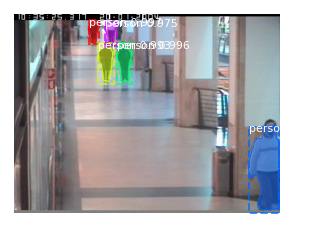

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


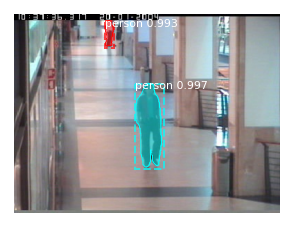

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


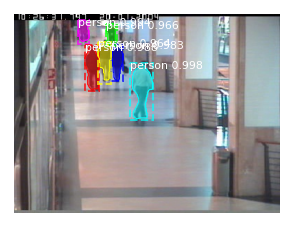

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


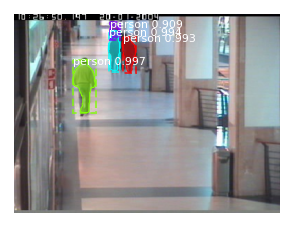

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


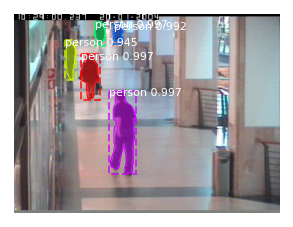

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


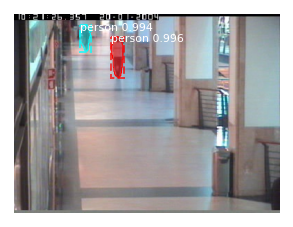

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


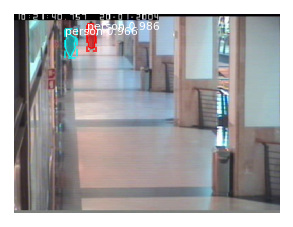

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


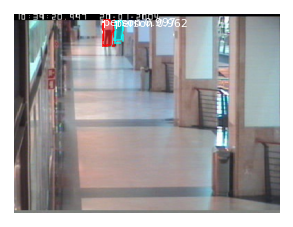

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


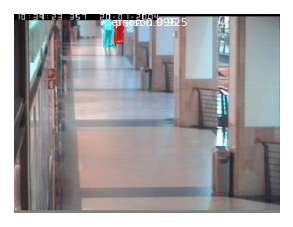

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


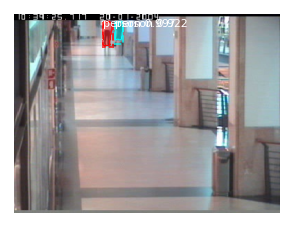

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


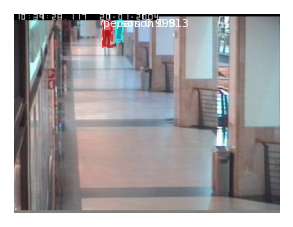

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


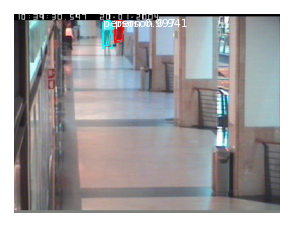

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


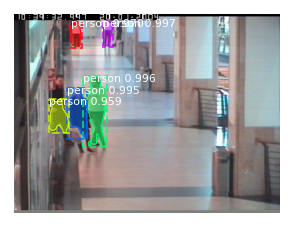

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


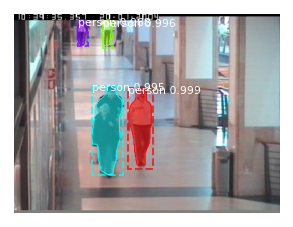

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


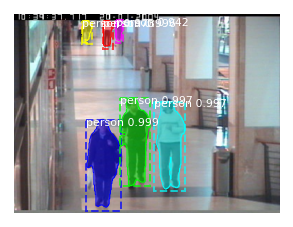

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


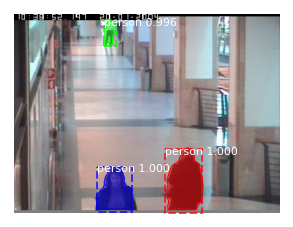

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


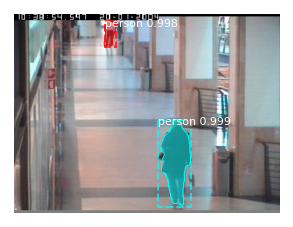

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


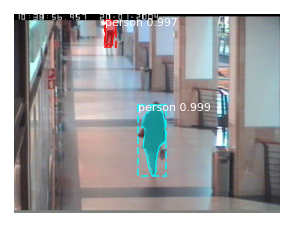

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


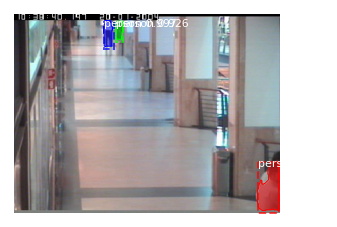

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


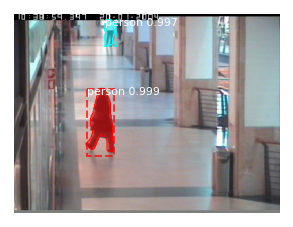

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


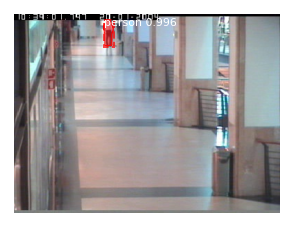

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


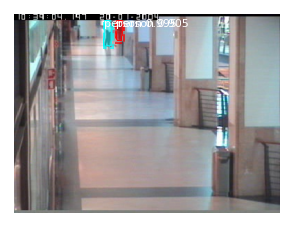

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


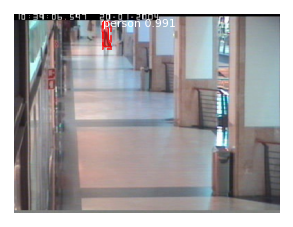

Processing 1 images
image                    shape: (288, 384, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  384.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


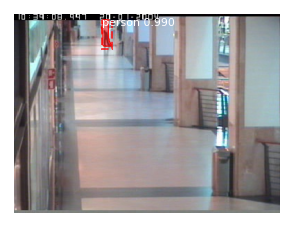

In [21]:
import skimage
real_test_dir = '../datasets/shopping in portugal/test/' #change this location of test_dir
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))